In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import openpyxl
import glob
from datetime import date

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set()

from fpdf import FPDF
pdf = FPDF()
import img2pdf

In [18]:
date = date.today()
str(date)

'2022-10-23'

In [22]:
# date = '2022-10-22'
fp_in = f'../data/tagui/gc_tickers_{date}.csv'
fp_out = f'../data/yfinance/gc_ticker_data_{date}.xlsx'
fp_plots = f'../data/plots/{date}'
pdf_path = f'../data/pdf'

In [3]:
ls = ['ACKB.BR', 'AFL', 'AIQUY', 'APD', 'ADM', 'ABW.MU', 'ATO', 'CNI', 'CAST.ST', 'CB', 'CTRA',
      'CMI', 'CVS', 'EMN', 'EMR', 'EOG', 'GIS', 'GPC', 'INTC', 'JNJ', 'DIP.BE', 'QPJ.BE', 'MTB',
      'MDT', 'MRU.TO', 'MIB.MU', 'MUV2.MI', 'NA.TO', 'NTT.SG', 'NVS', 'OMC', 'ORK.OL', 'PH', 'REC.MI',
      'RHHBY', 'RBSFY', 'SNYNF', 'QSU.SG', '9SG.HM', 'SHECY', 'SNA', 'SKHCF', 'TGT', 'UCBI', 'UL', 'WMT']

In [4]:
stock_description = {}
stock_industry = {}
stock_name = {}

df = pd.DataFrame()
for i in ls:
    stock = yf.Ticker(f'{i}') # returns a DataFrame
    
    try:
        stock_description[i] = stock.info['longBusinessSummary']
    except:
        stock_description[i] = 'UNKNOWN'
    try:
        stock_industry[i] = stock.info['industry']
    except:
        stock_industry[i] = 'UNKNOWN'
    stock_name[i] = stock.info['shortName']
    
    hist = stock.history(period="2y")
    hist['Stock'] = i
    
    df = pd.concat([df, hist], axis=0)
    # print(df.shape)
    # break
df.sample(5)

Open       High        Low      Close  \
Date                                                                    
2020-11-13 00:00:00-05:00   6.757286   6.757286   6.757286   6.757286   
2021-02-04 00:00:00-05:00  16.905802  17.021535  16.701045  16.798973   
2021-10-13 00:00:00+02:00  13.725368  13.725368  13.725368  13.725368   
2022-07-07 00:00:00-04:00  92.569736  93.350457  92.213964  92.629036   
2022-01-26 00:00:00-05:00  90.780189  91.261753  88.382182  89.020996   

                              Volume  Dividends  Stock Splits   Stock  
Date                                                                   
2020-11-13 00:00:00-05:00        0.0        0.0           0.0   RBSFY  
2021-02-04 00:00:00-05:00  4326200.0        0.0           0.0    CTRA  
2021-10-13 00:00:00+02:00        0.0        0.0           0.0  MIB.MU  
2022-07-07 00:00:00-04:00  3536400.0        0.0           0.0     CVS  
2022-01-26 00:00:00-05:00  4230000.0        0.0           0.0     EMR

In [5]:
tmp = df.copy()
tmp = tmp.reset_index()
tmp['Date'] = tmp['Date'].astype(str)

In [6]:
# tmp.to_excel(fp)

In [7]:
# tmp.drop(['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Adj Close'], inplace = True, axis=1)
tmp.drop(['Open', 'High', 'Low', 'Dividends', 'Stock Splits'], inplace = True, axis=1)
tmp.head()

Date       Close   Volume    Stock
0  2020-10-21 00:00:00+02:00  104.535545  24733.0  ACKB.BR
1  2020-10-22 00:00:00+02:00  104.724915  24753.0  ACKB.BR
2  2020-10-23 00:00:00+02:00  106.808067  20586.0  ACKB.BR
3  2020-10-26 00:00:00+01:00  103.872726  21036.0  ACKB.BR
4  2020-10-27 00:00:00+01:00  102.263031  25257.0  ACKB.BR

In [8]:
tmp['Date'] = pd.to_datetime(tmp['Date'], format='%Y-%m-%d %H:%M:%S')
tmp.head()

Date       Close   Volume    Stock
0  2020-10-21 00:00:00+02:00  104.535545  24733.0  ACKB.BR
1  2020-10-22 00:00:00+02:00  104.724915  24753.0  ACKB.BR
2  2020-10-23 00:00:00+02:00  106.808067  20586.0  ACKB.BR
3  2020-10-26 00:00:00+01:00  103.872726  21036.0  ACKB.BR
4  2020-10-27 00:00:00+01:00  102.263031  25257.0  ACKB.BR

/home/raoulbia/opt/miniconda3/envs/trading/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


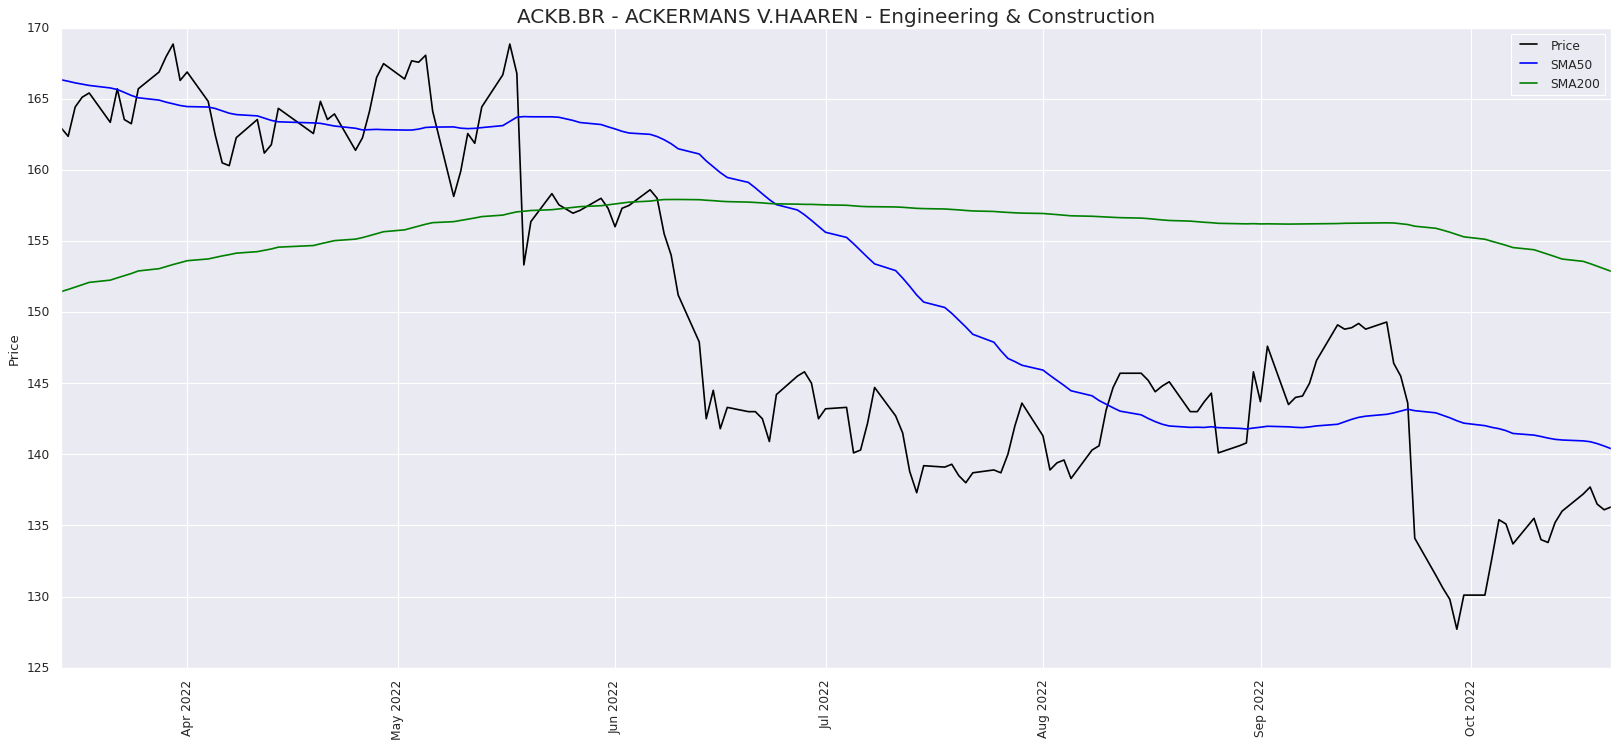

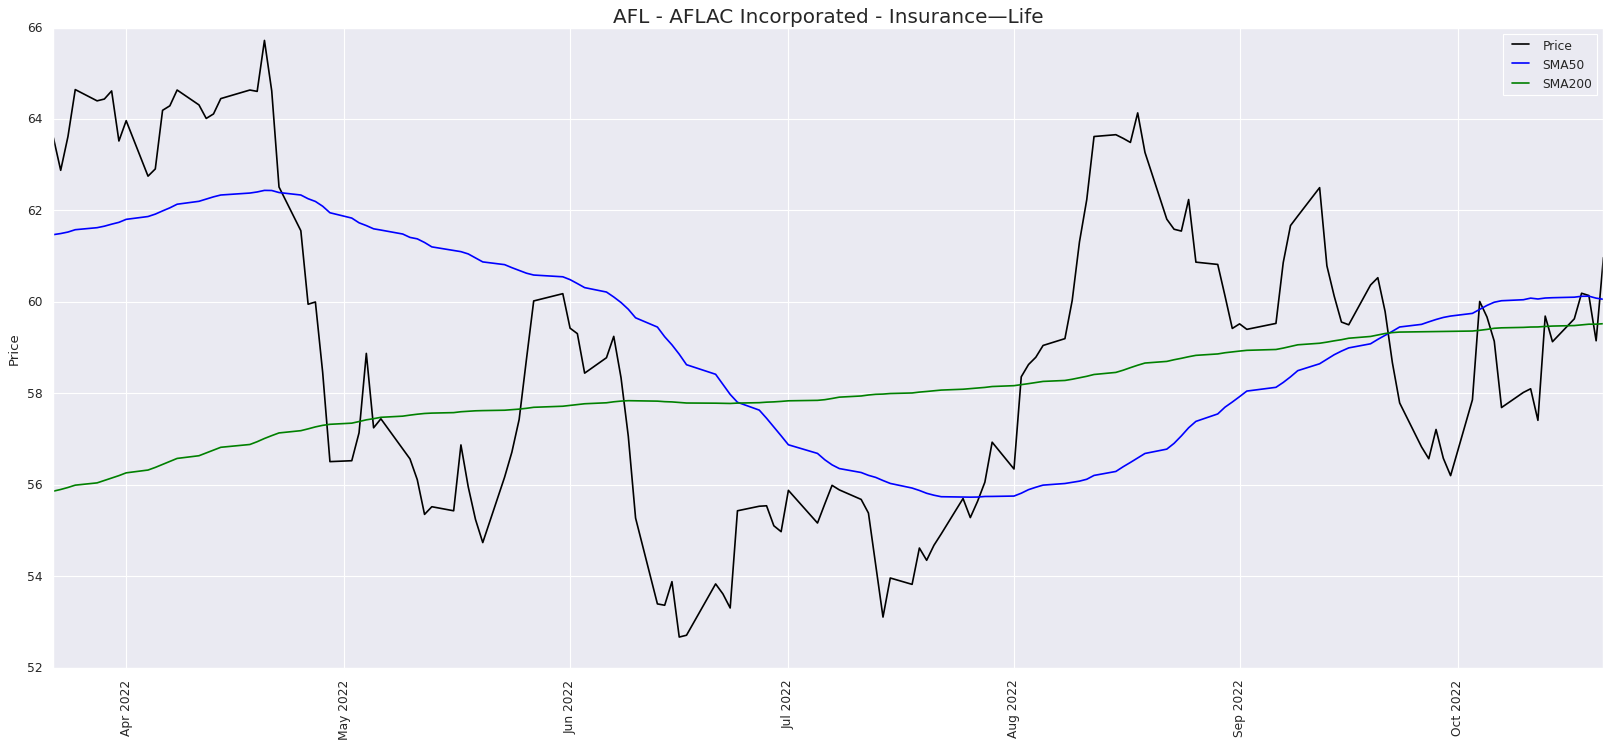

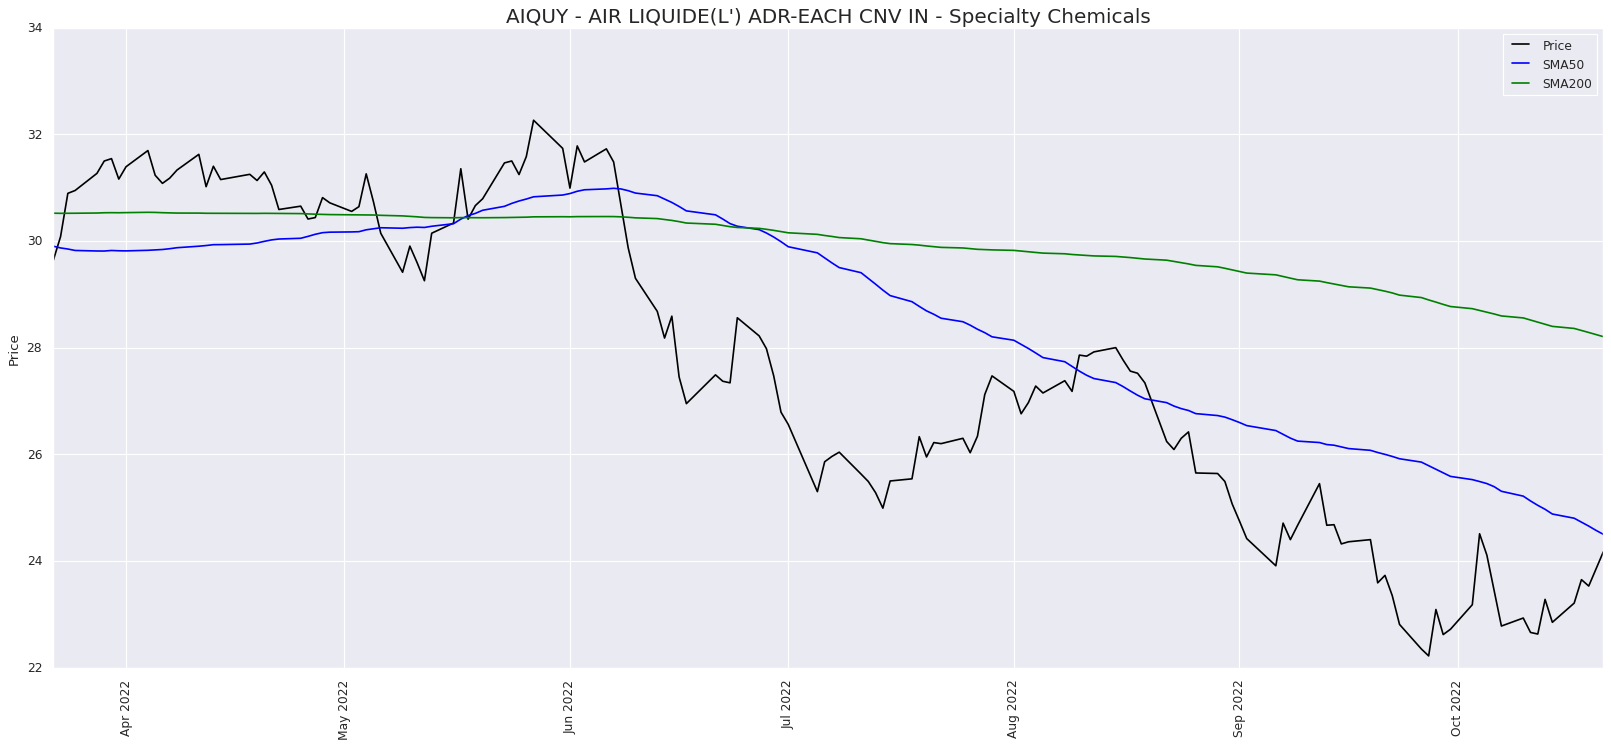

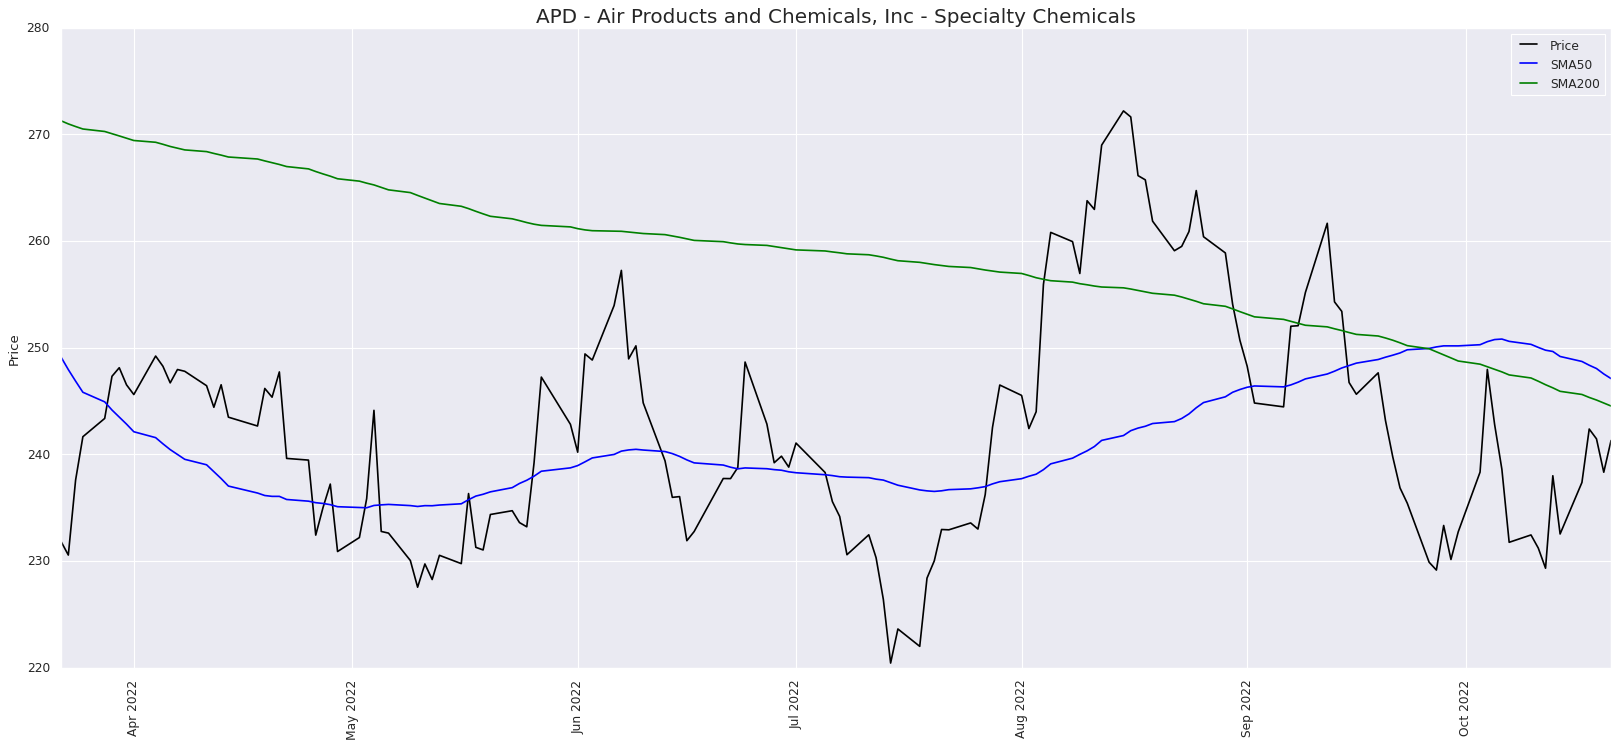

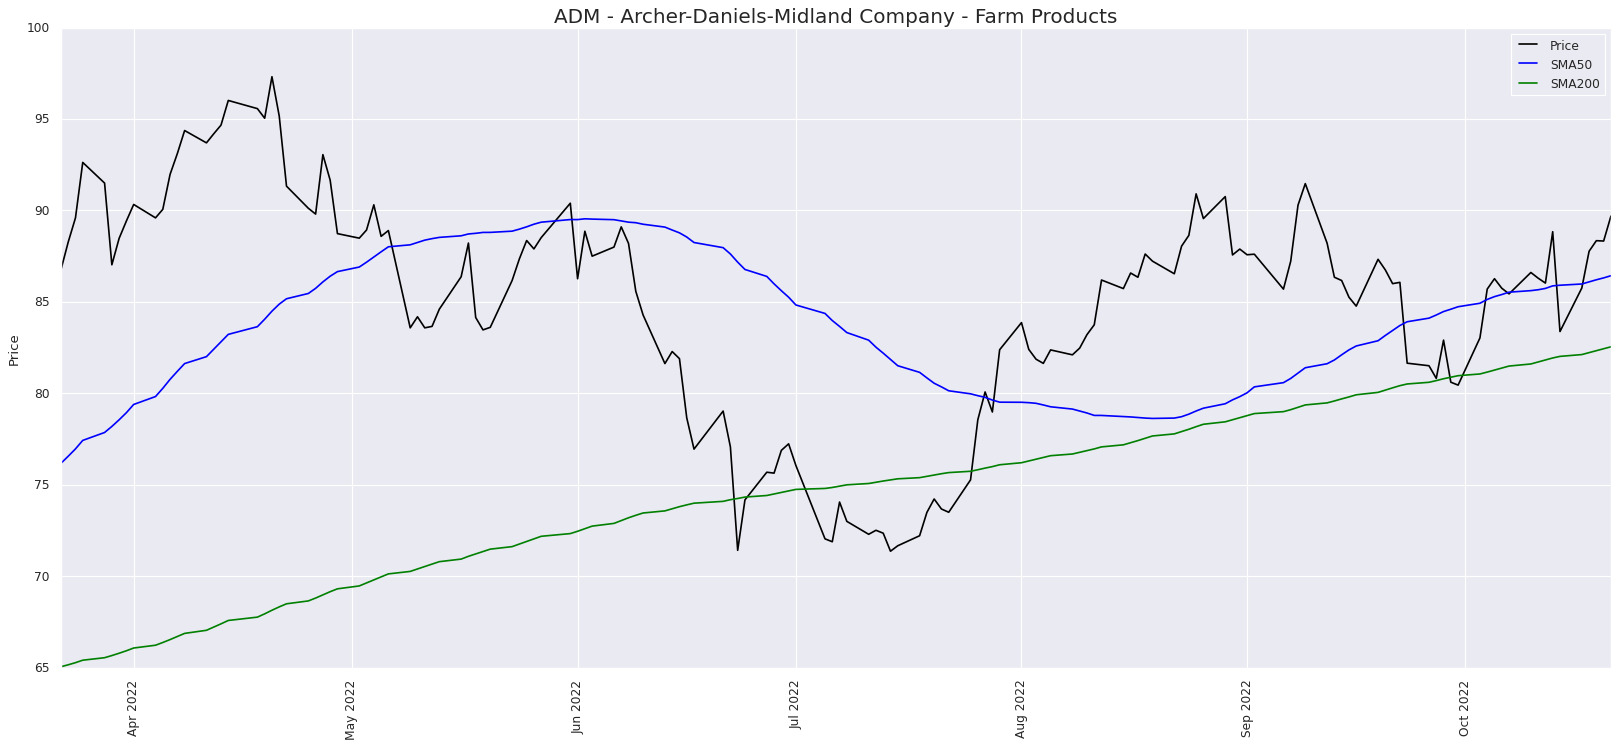

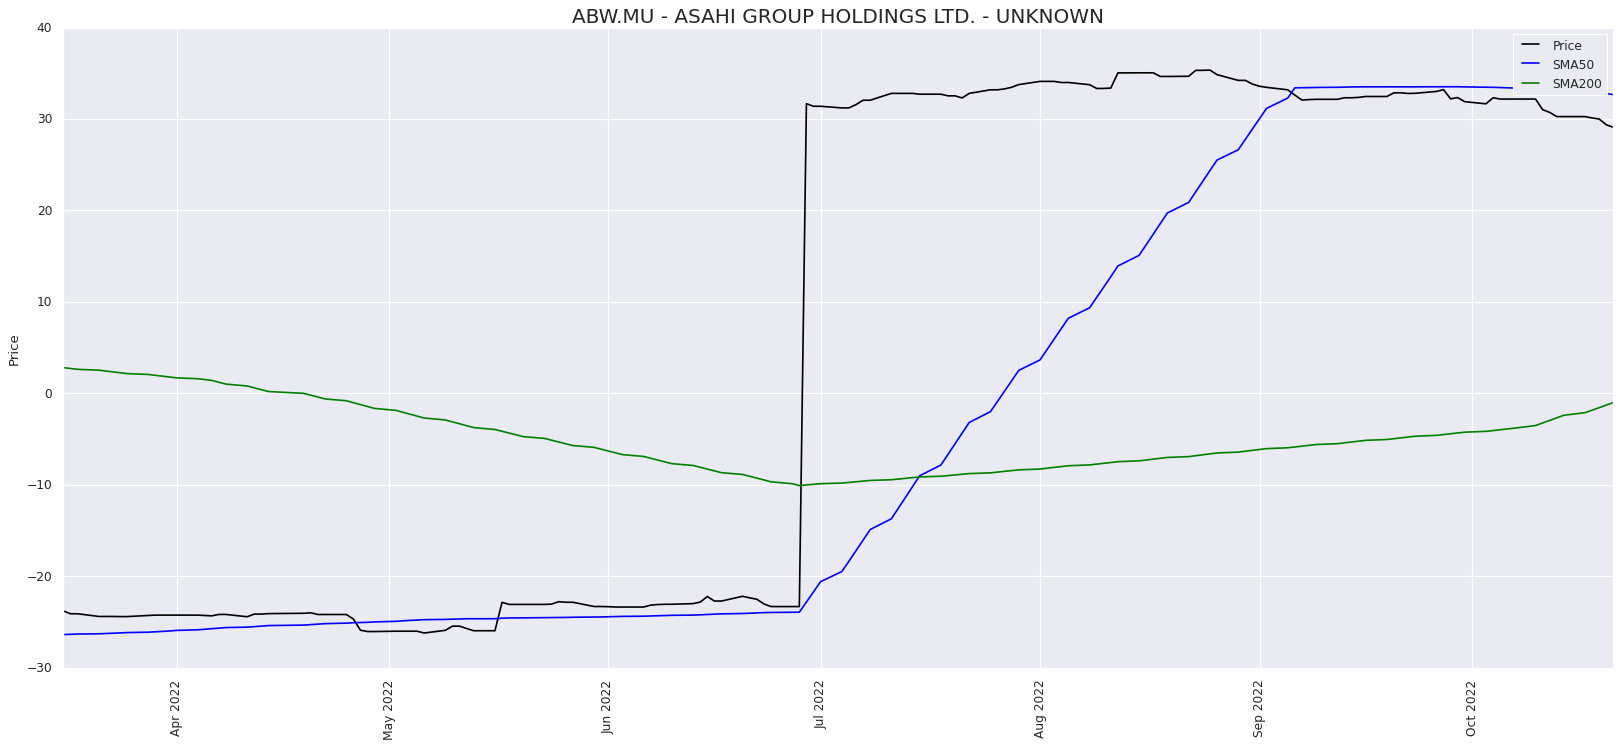

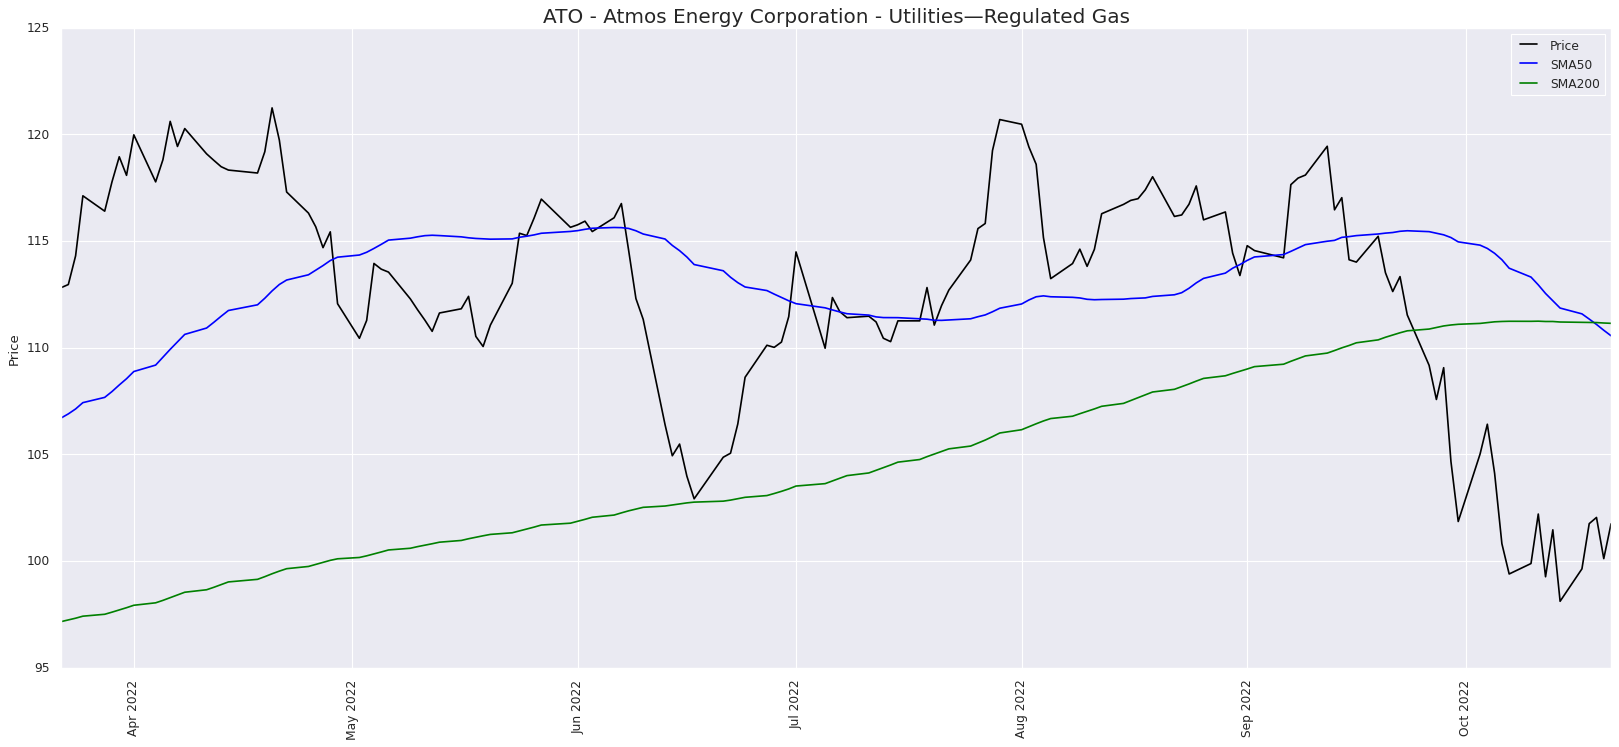

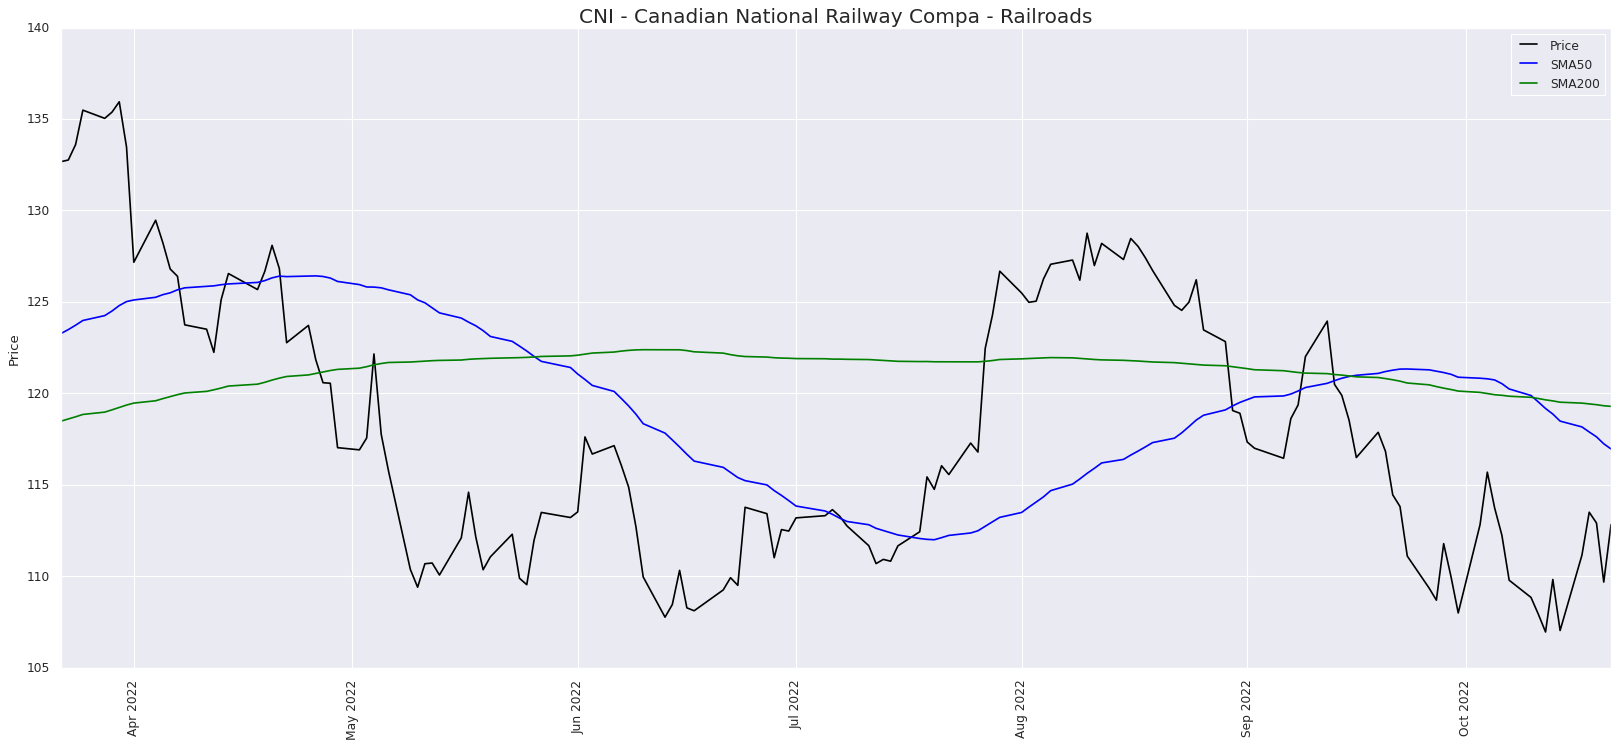

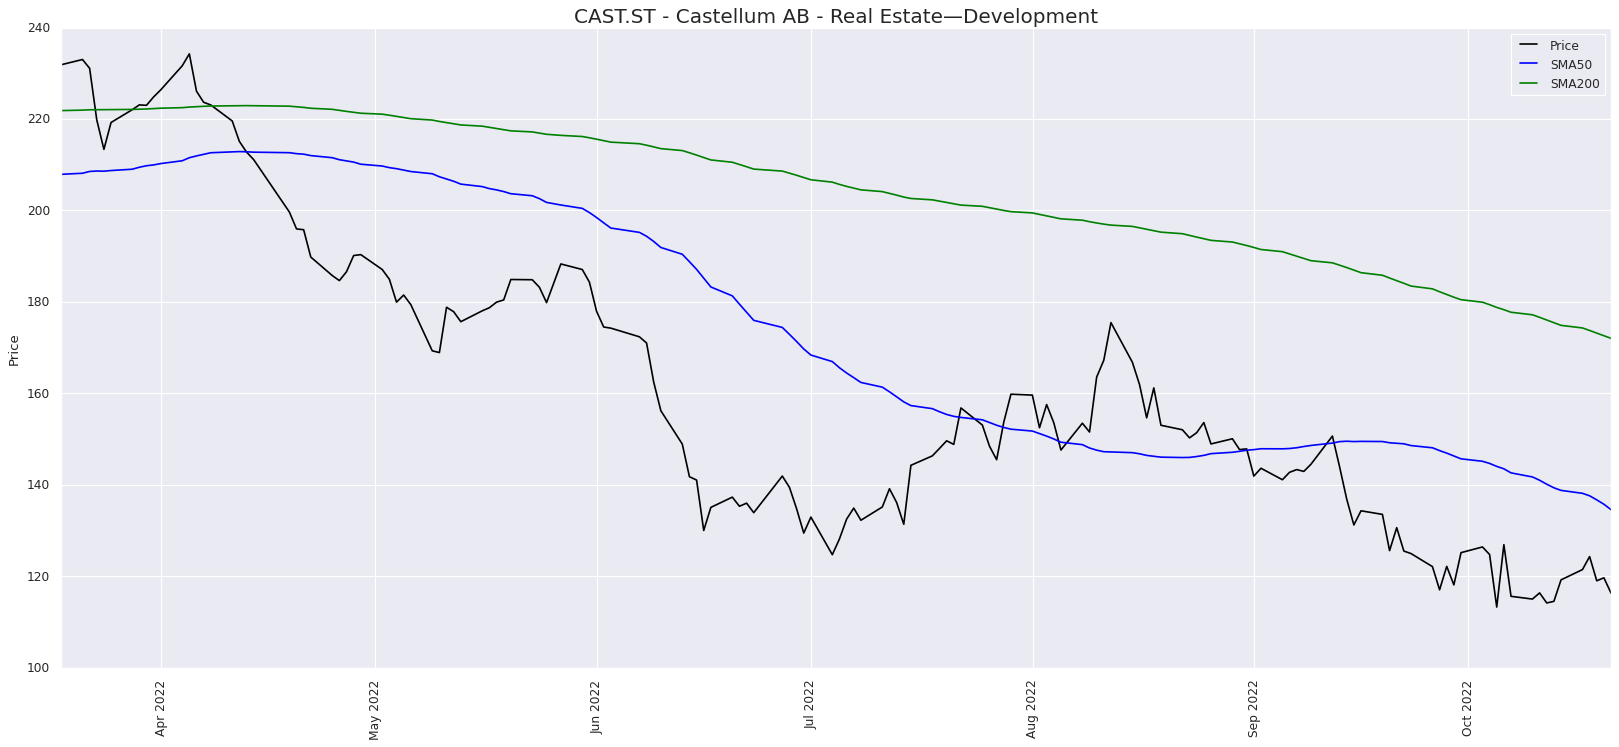

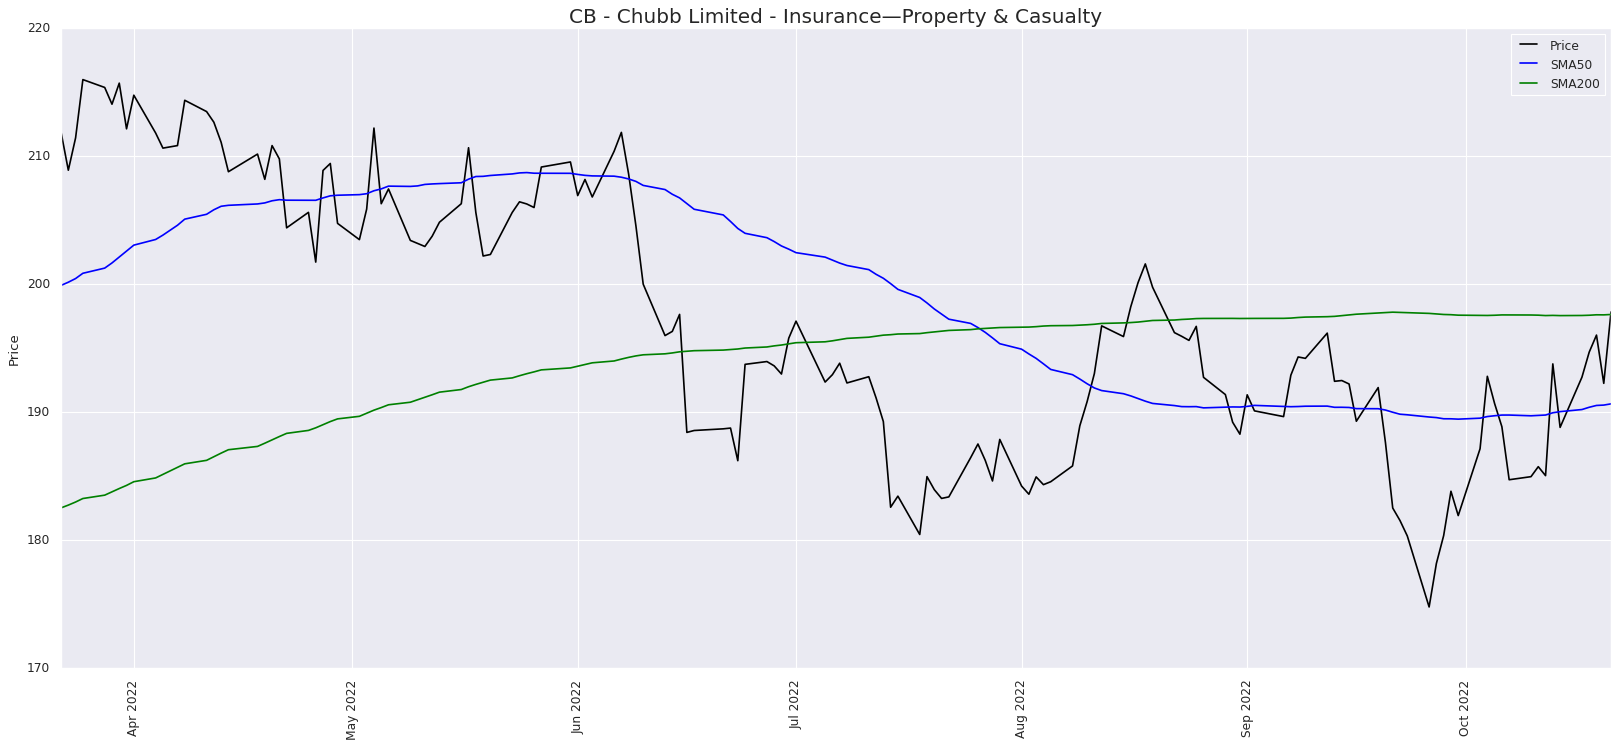

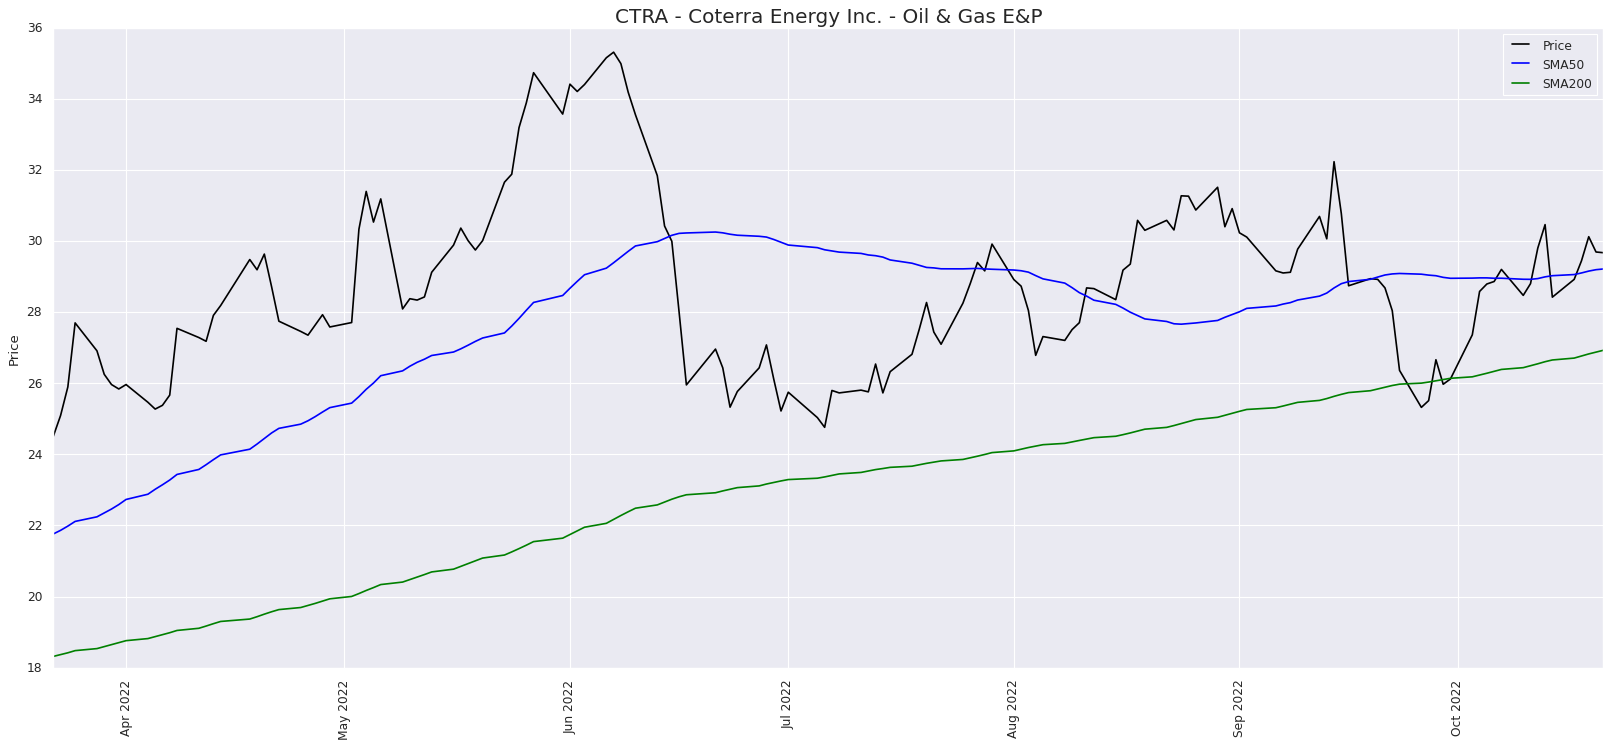

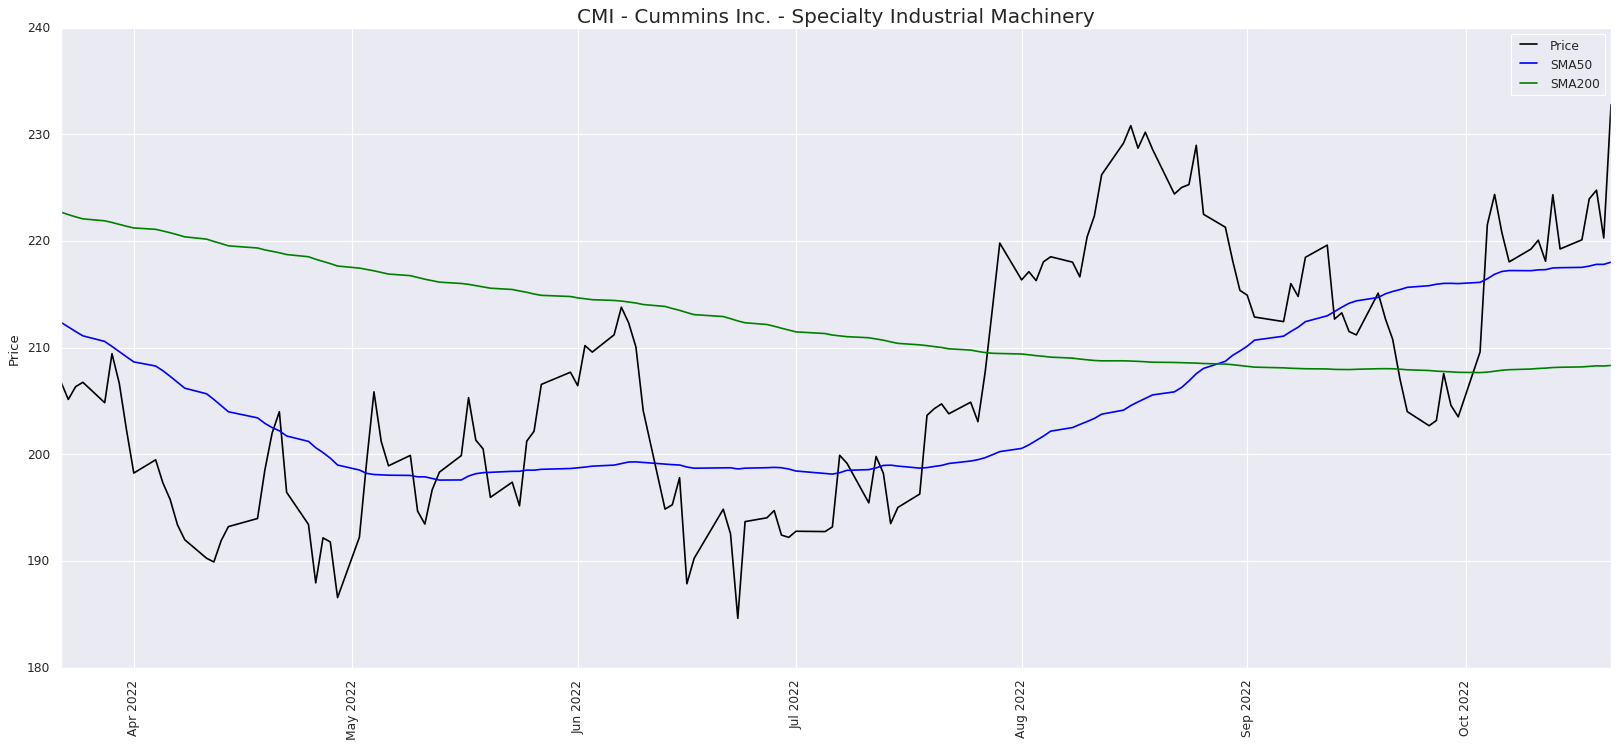

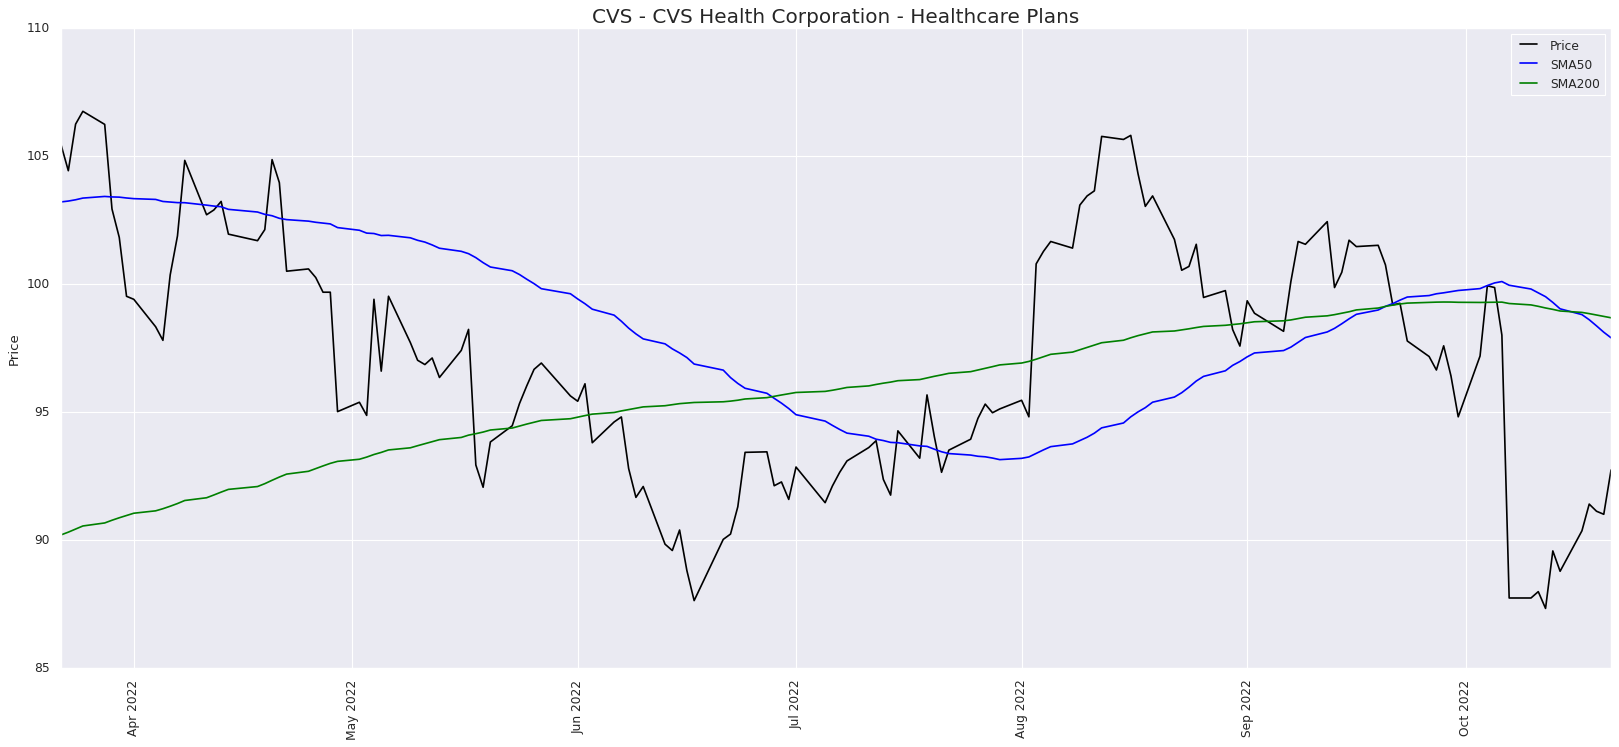

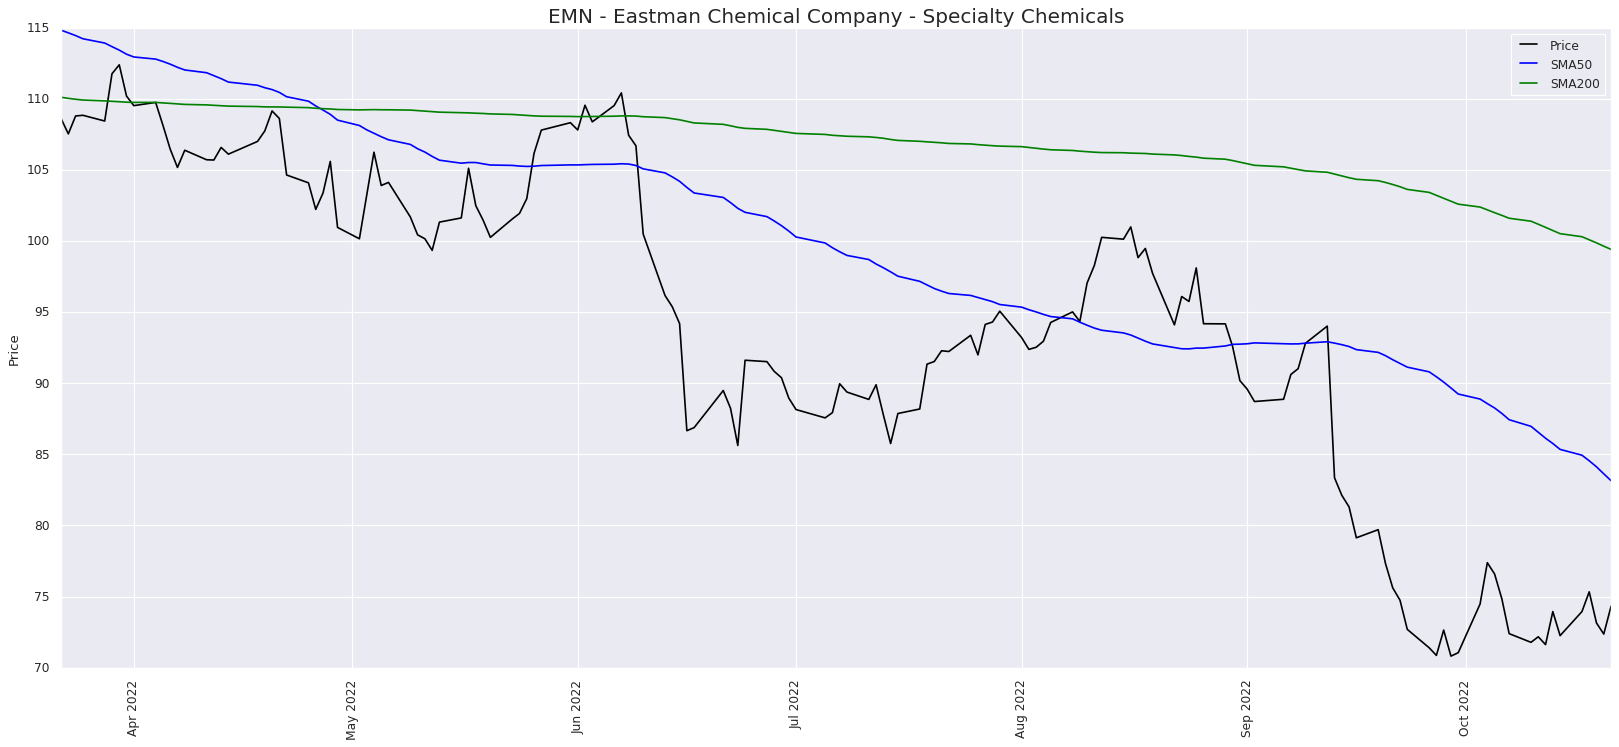

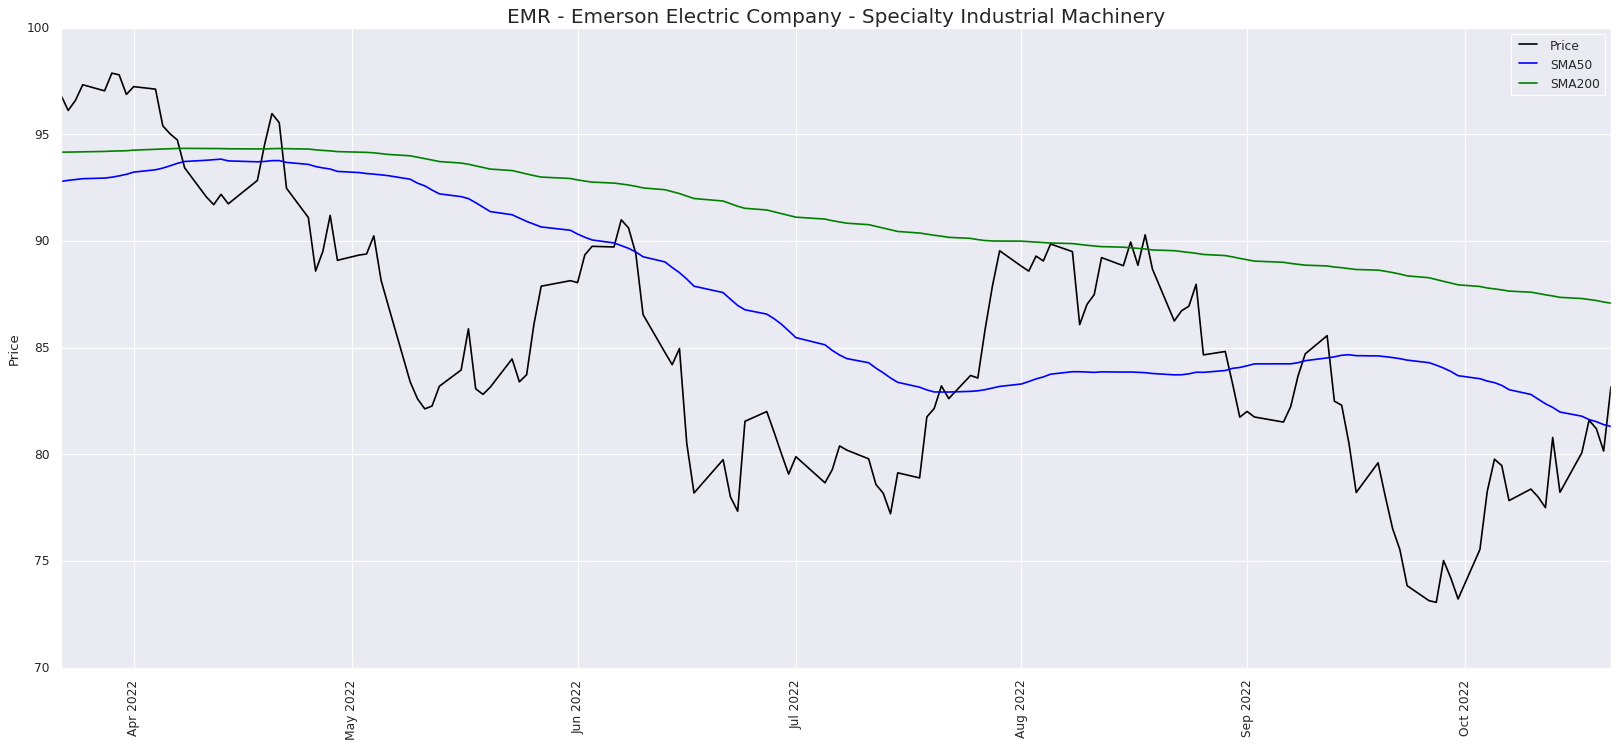

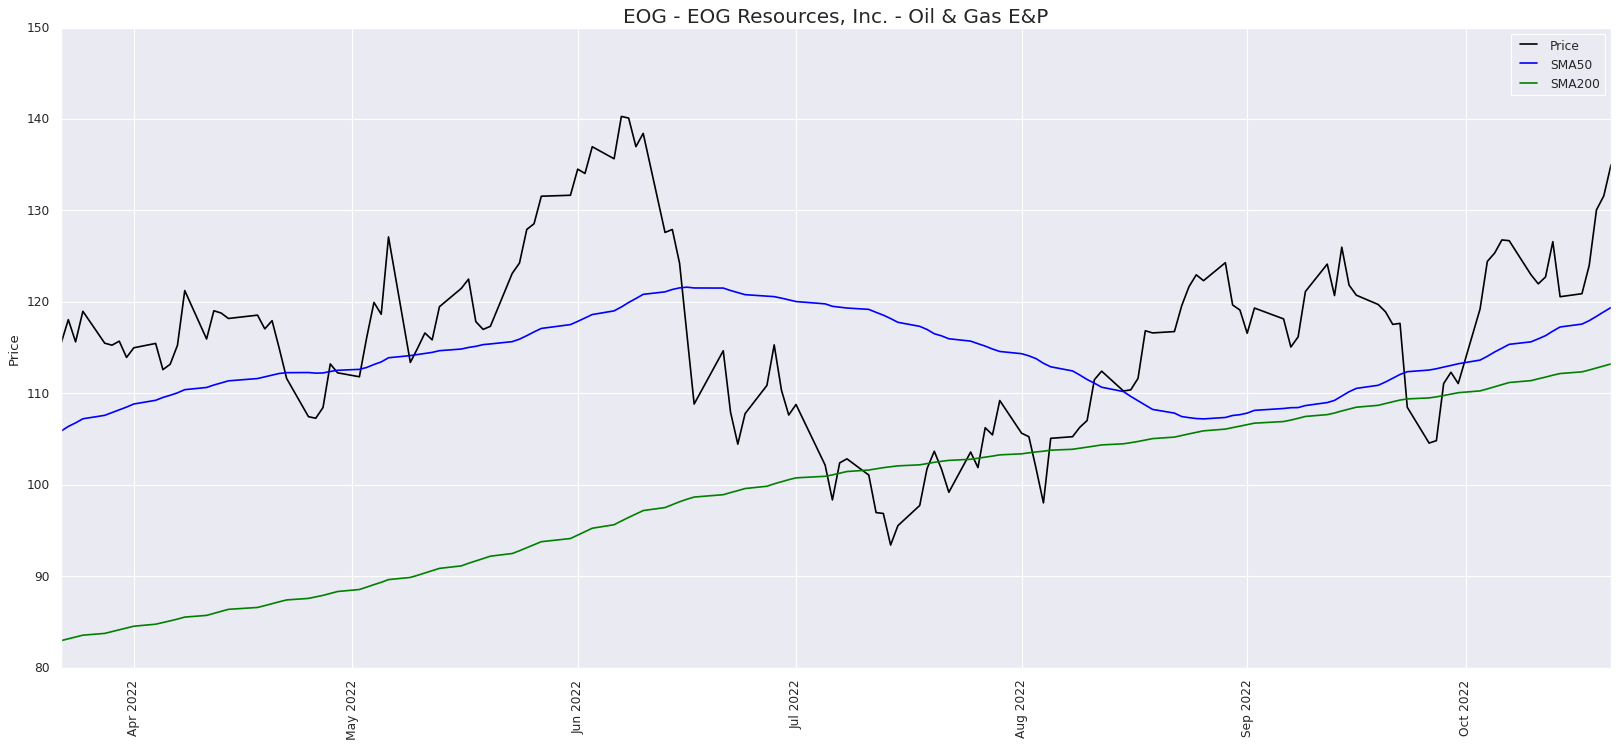

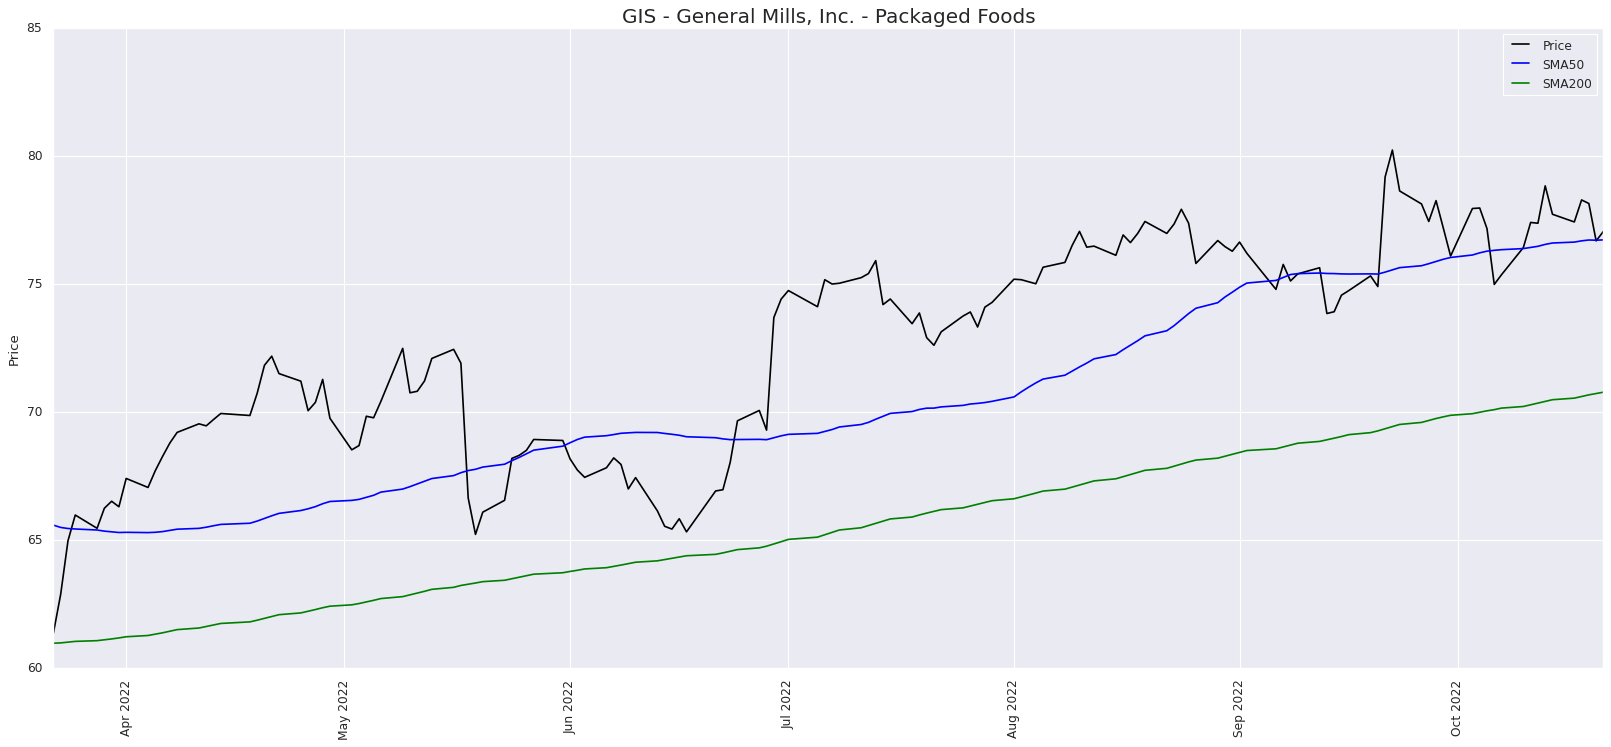

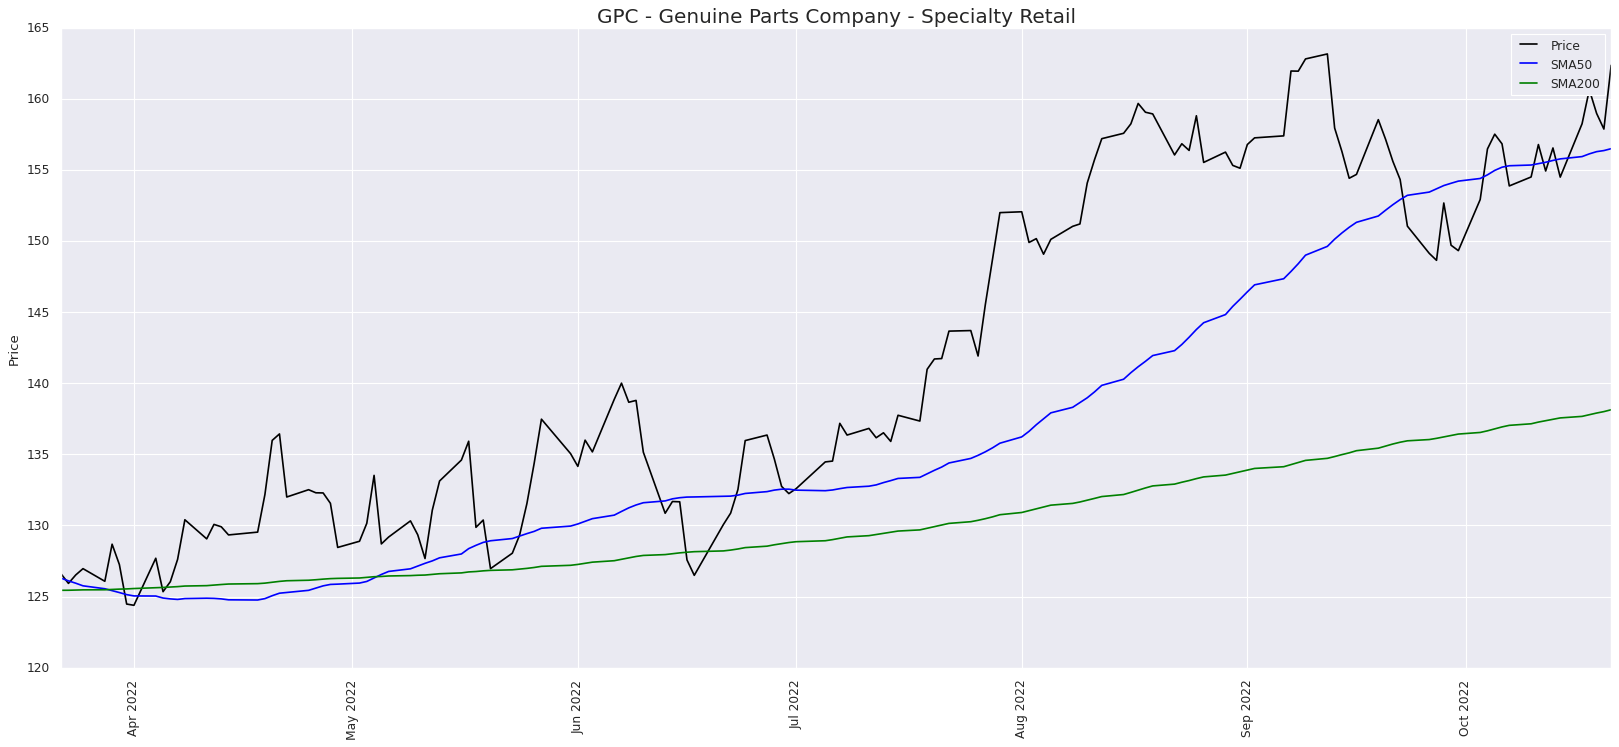

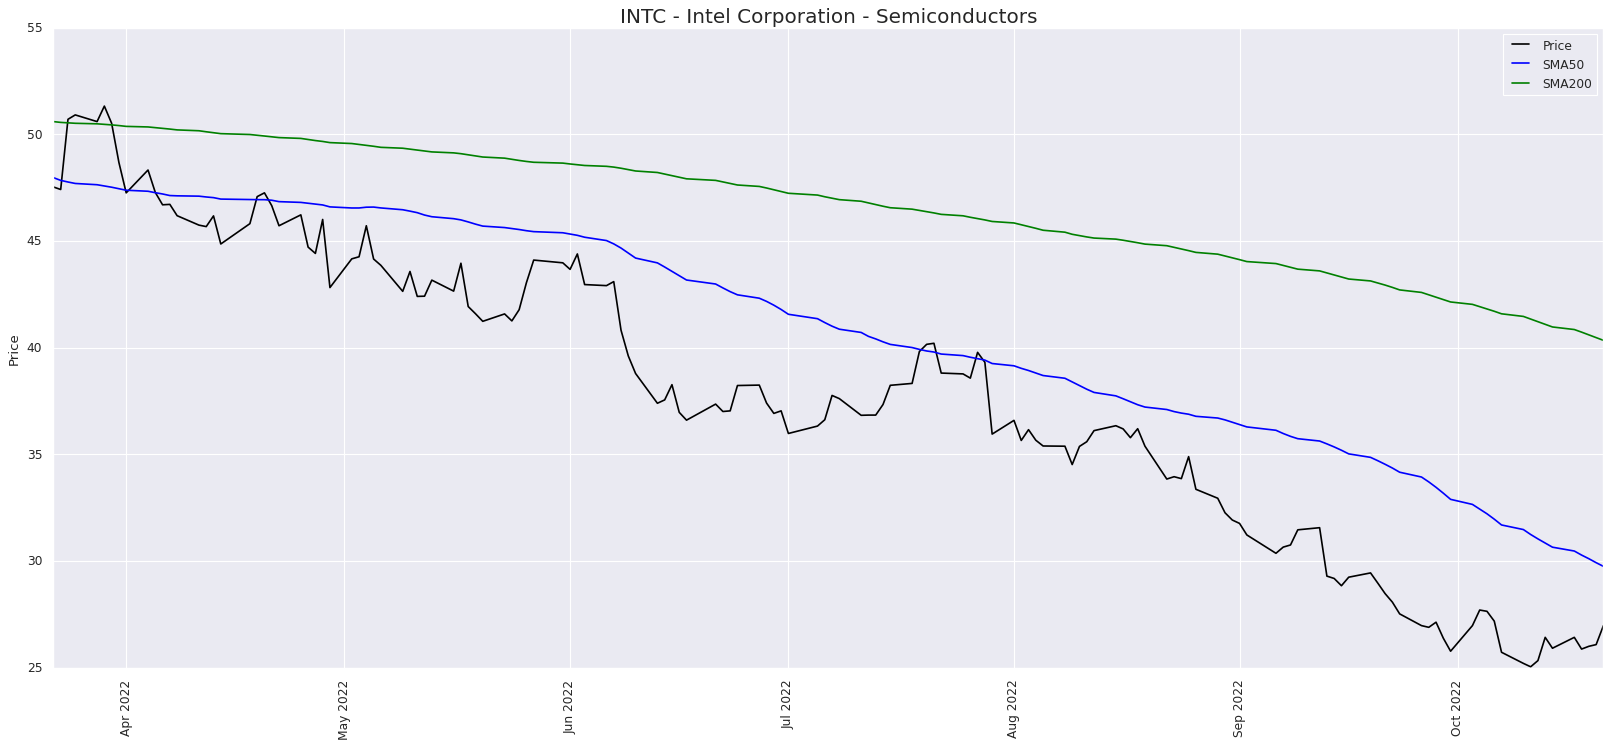

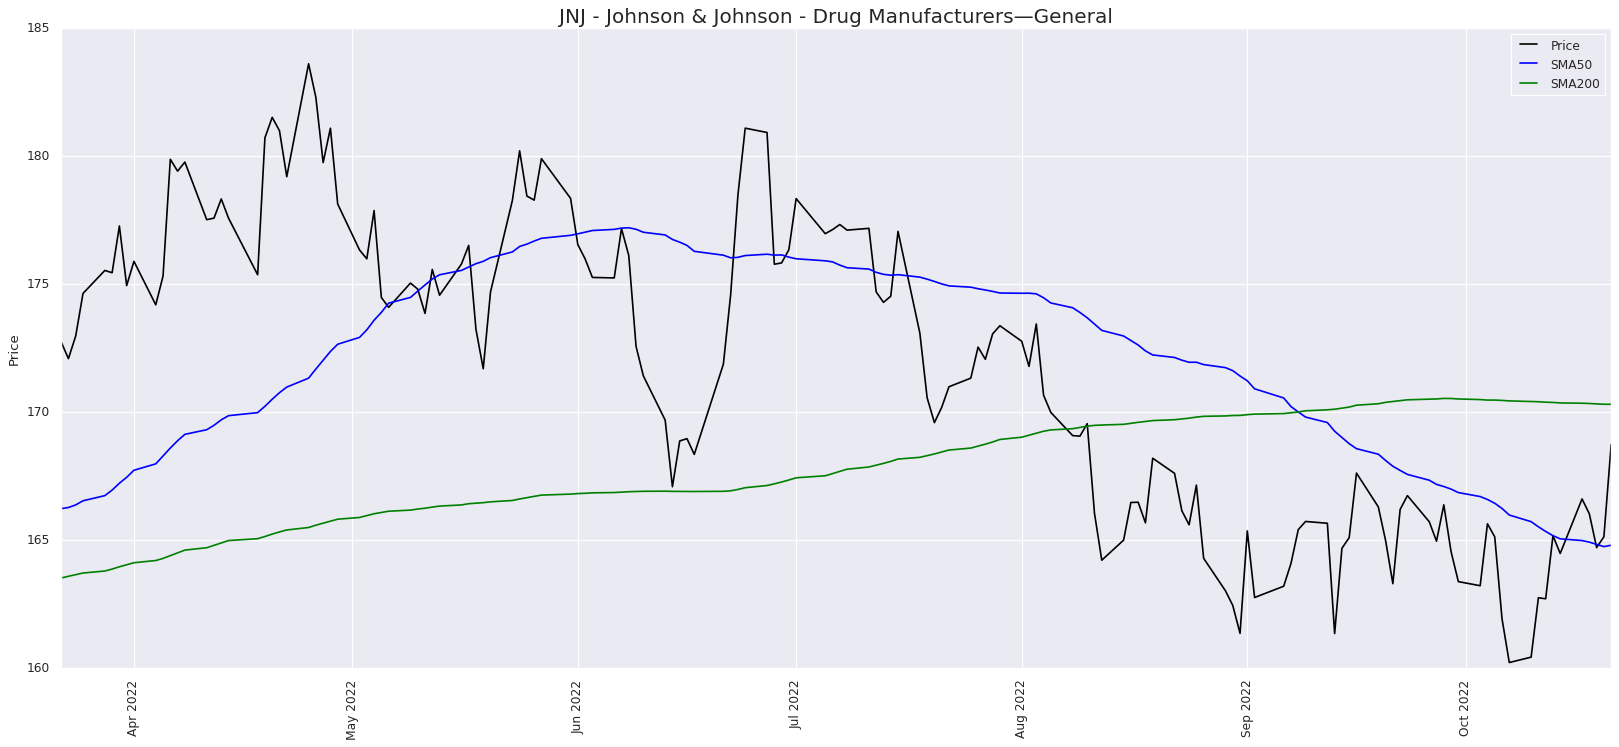

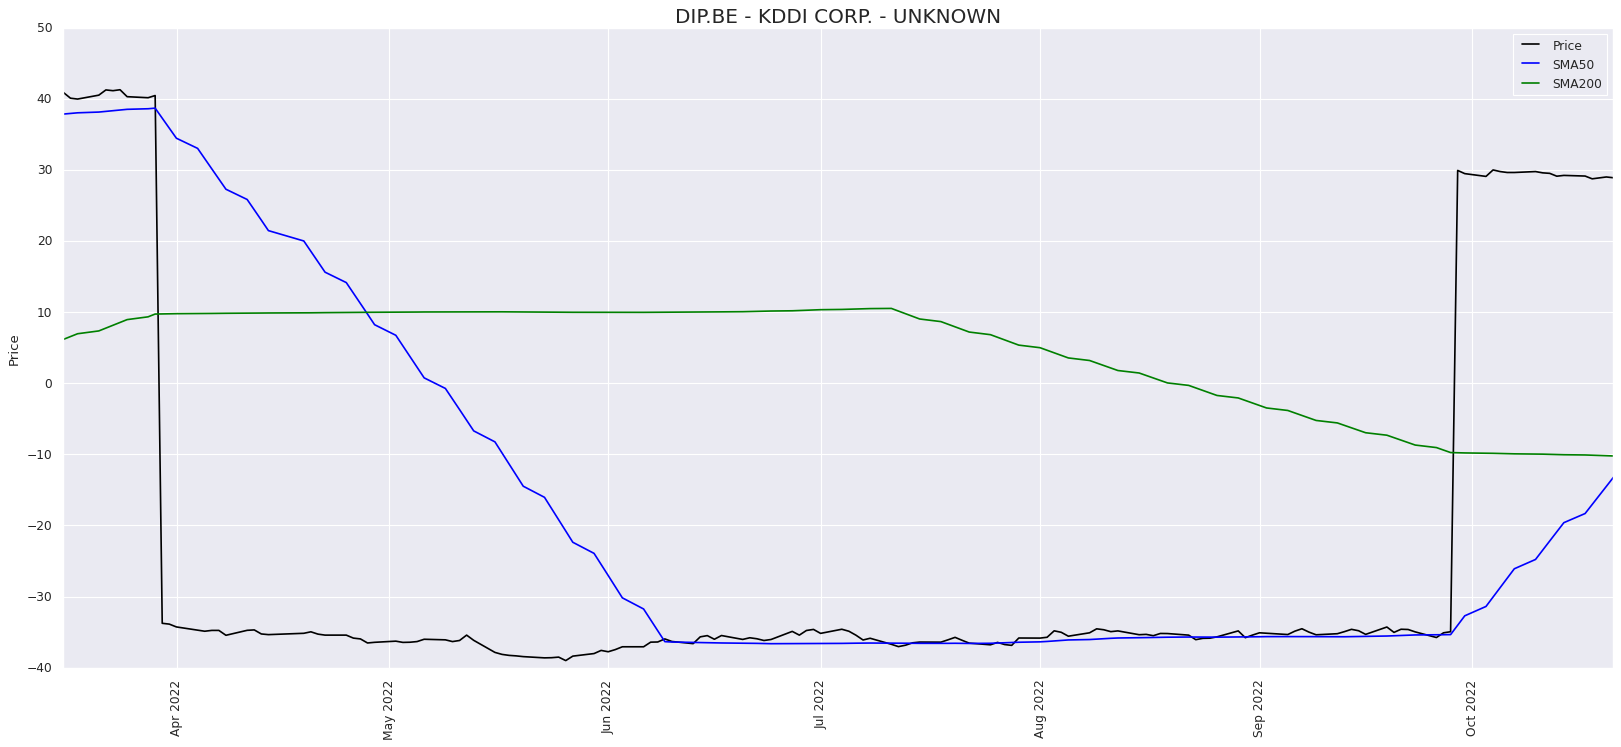

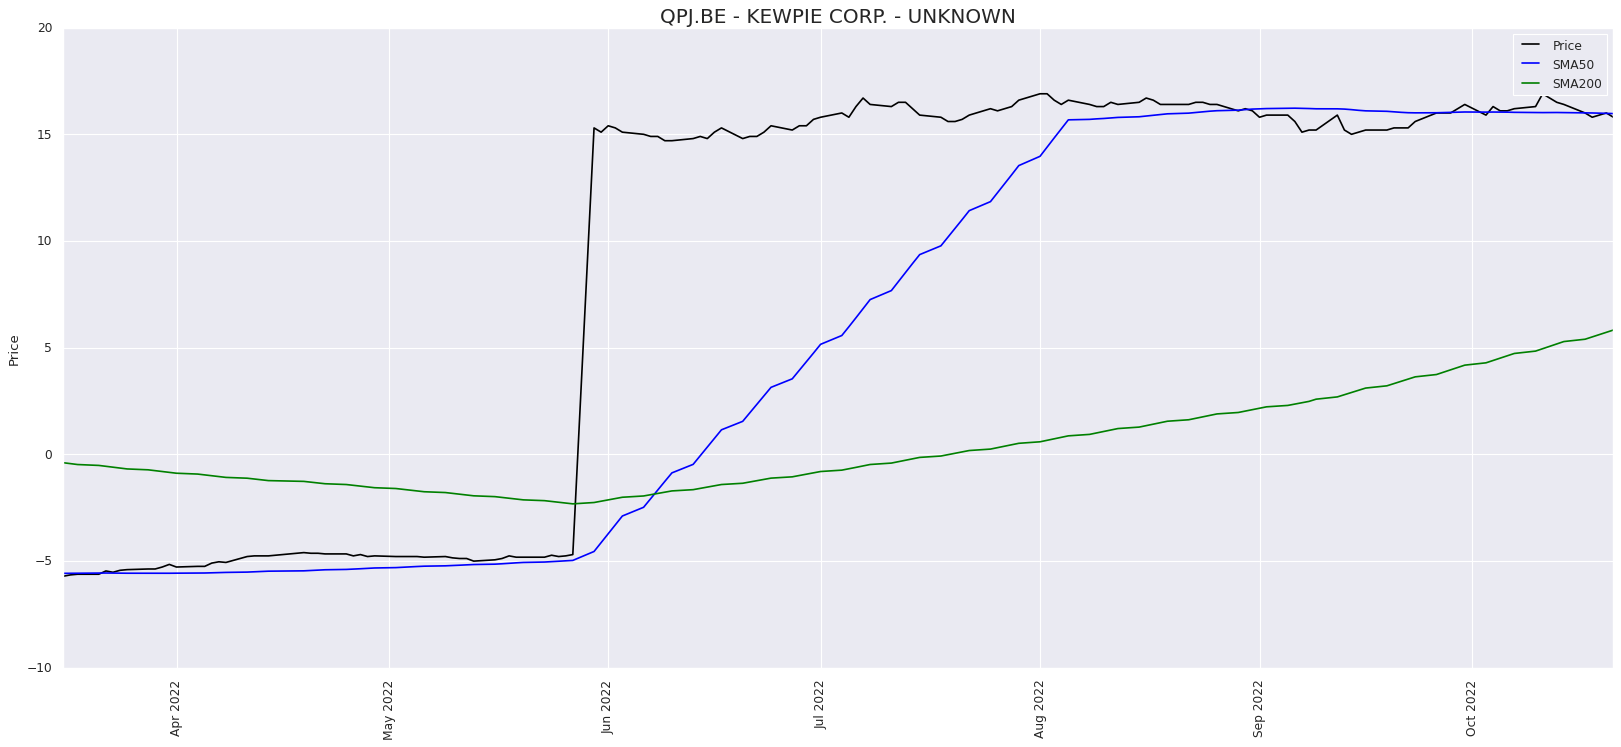

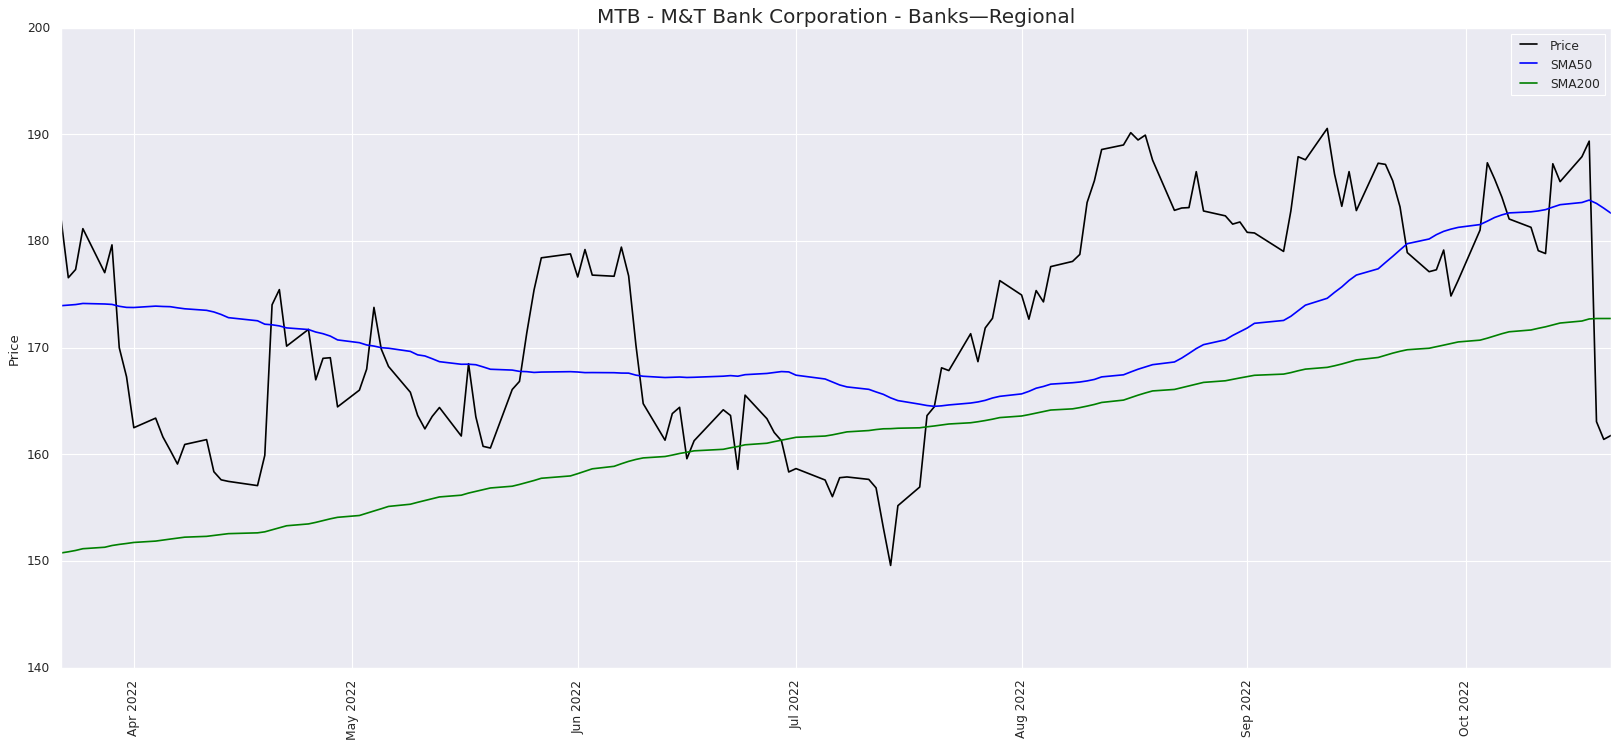

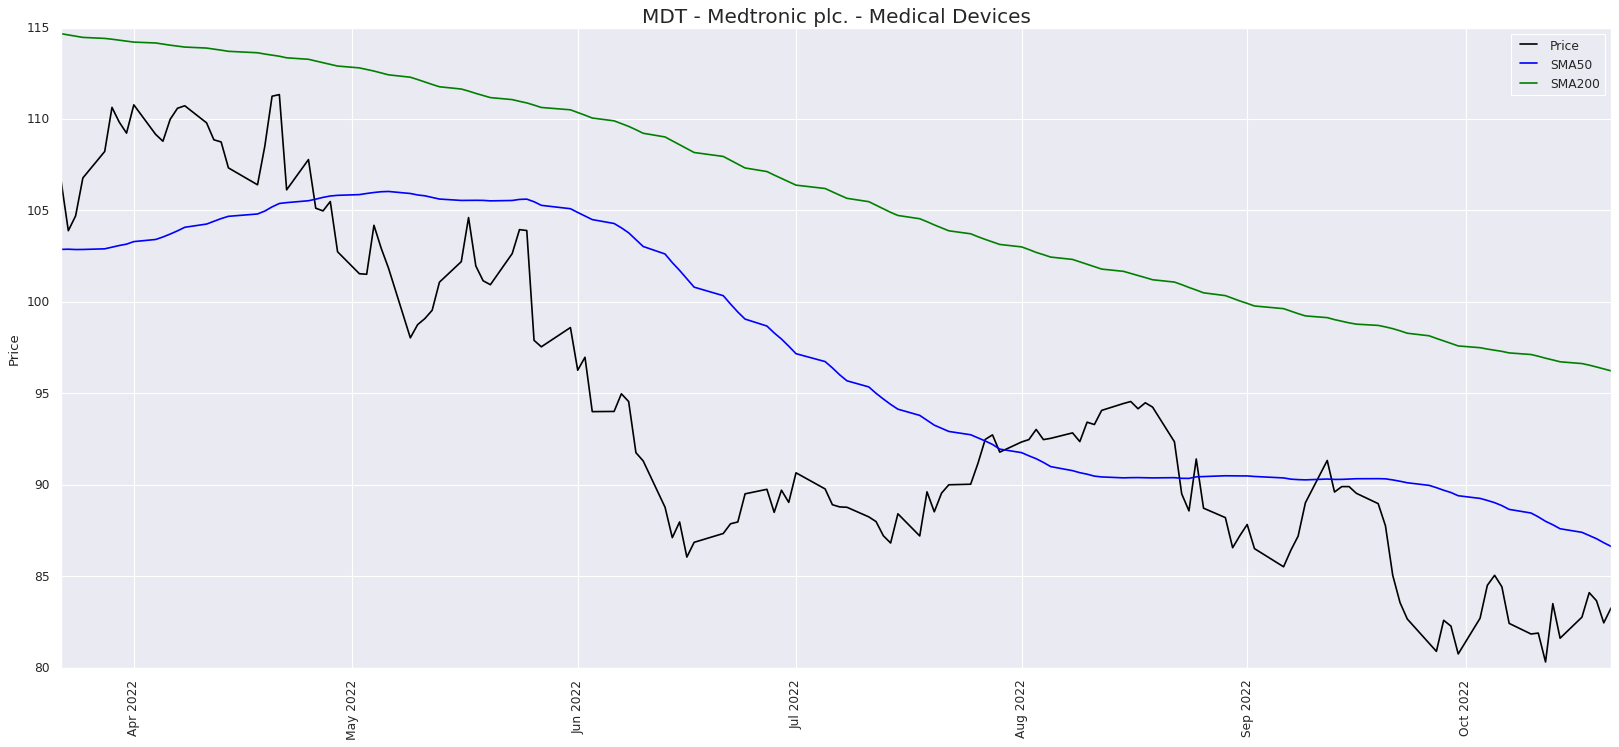

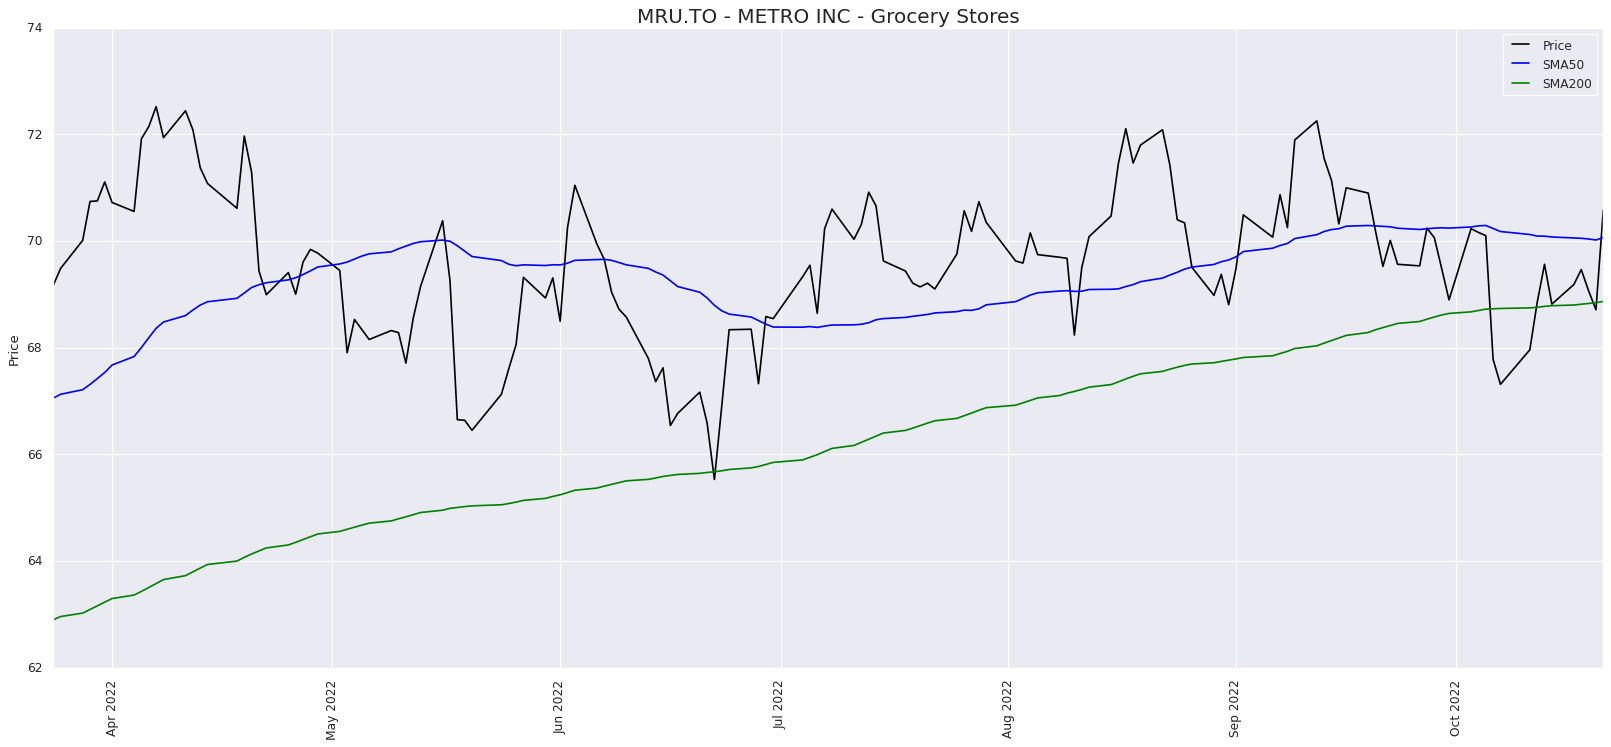

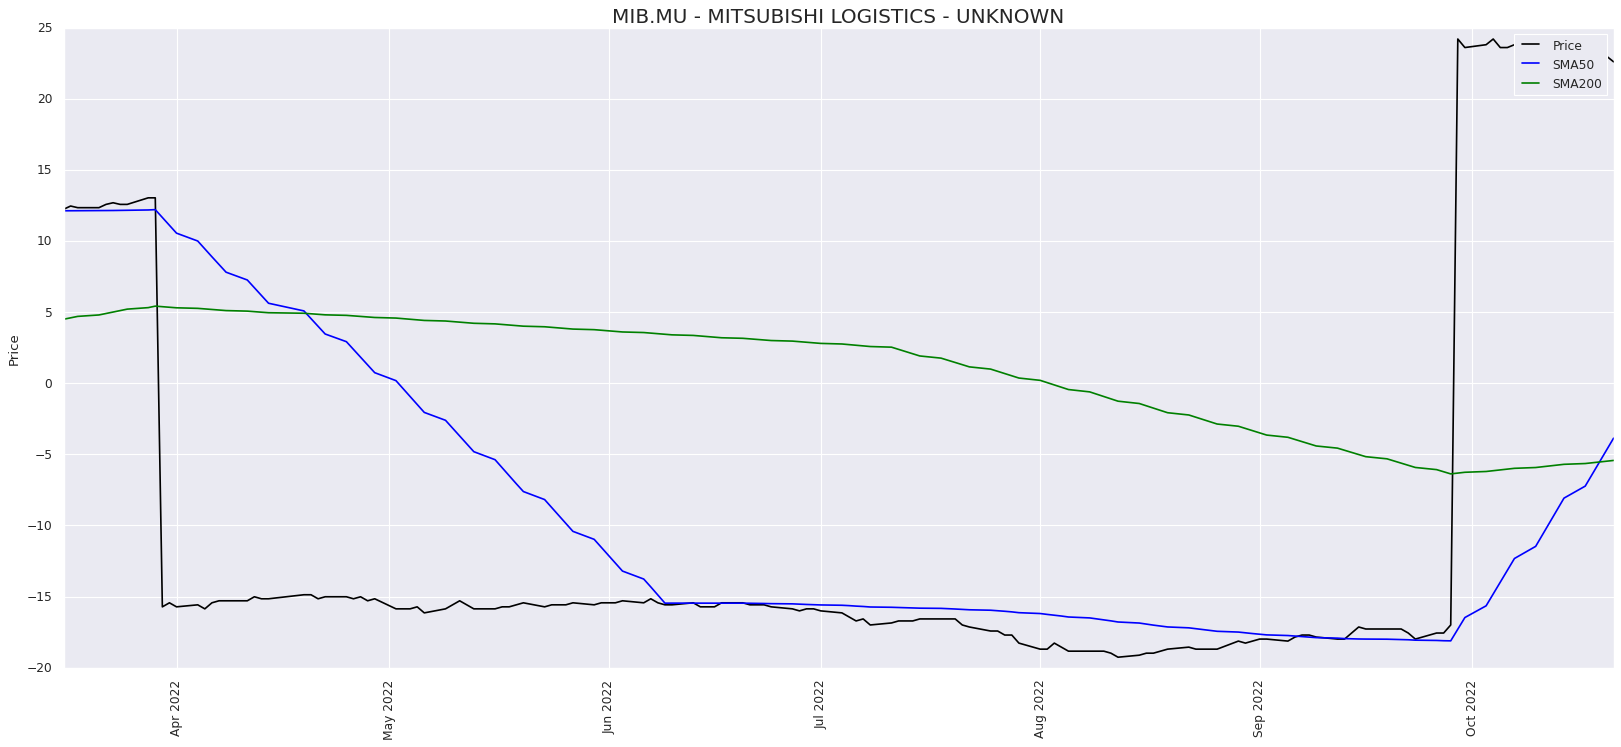

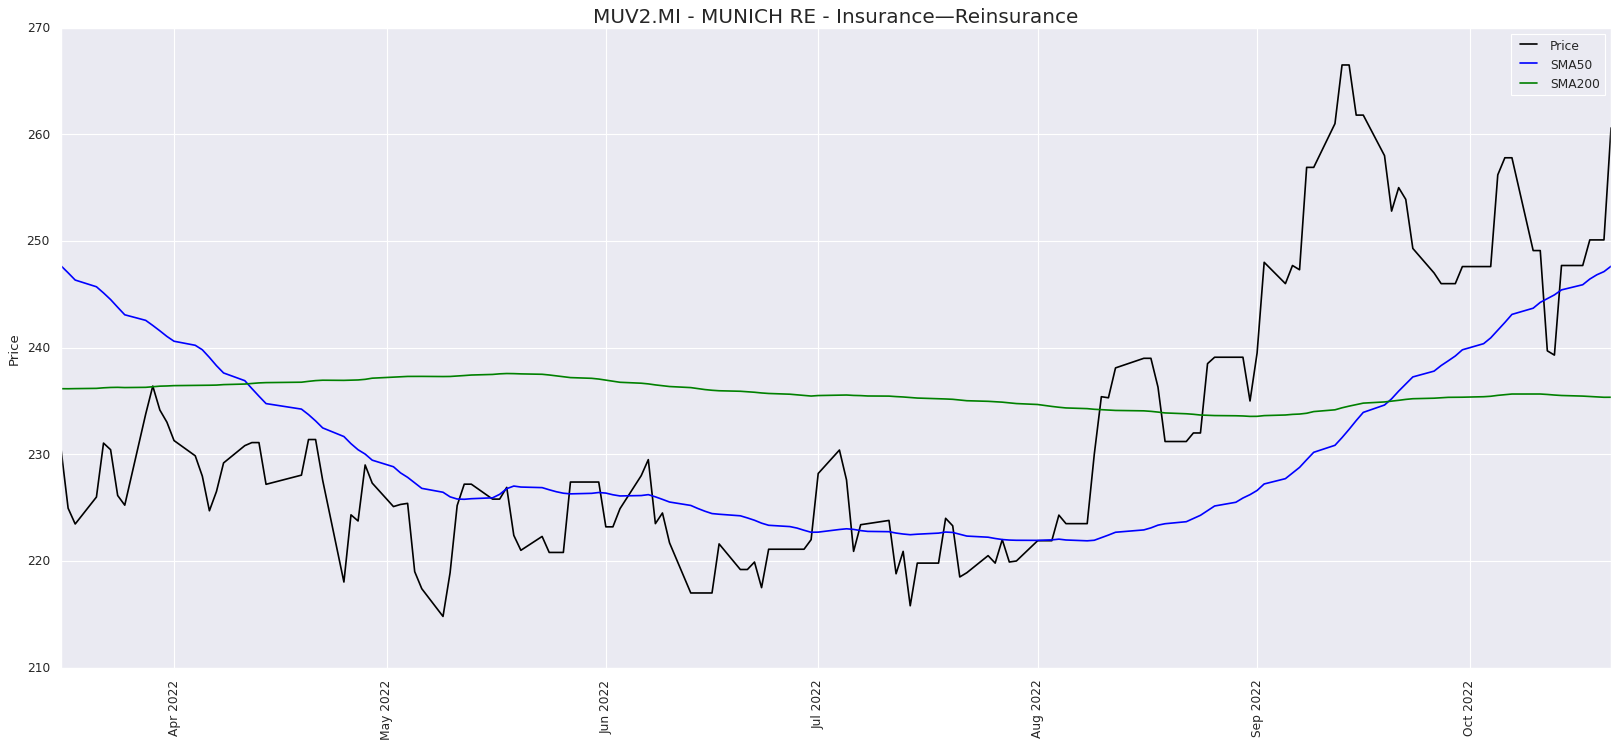

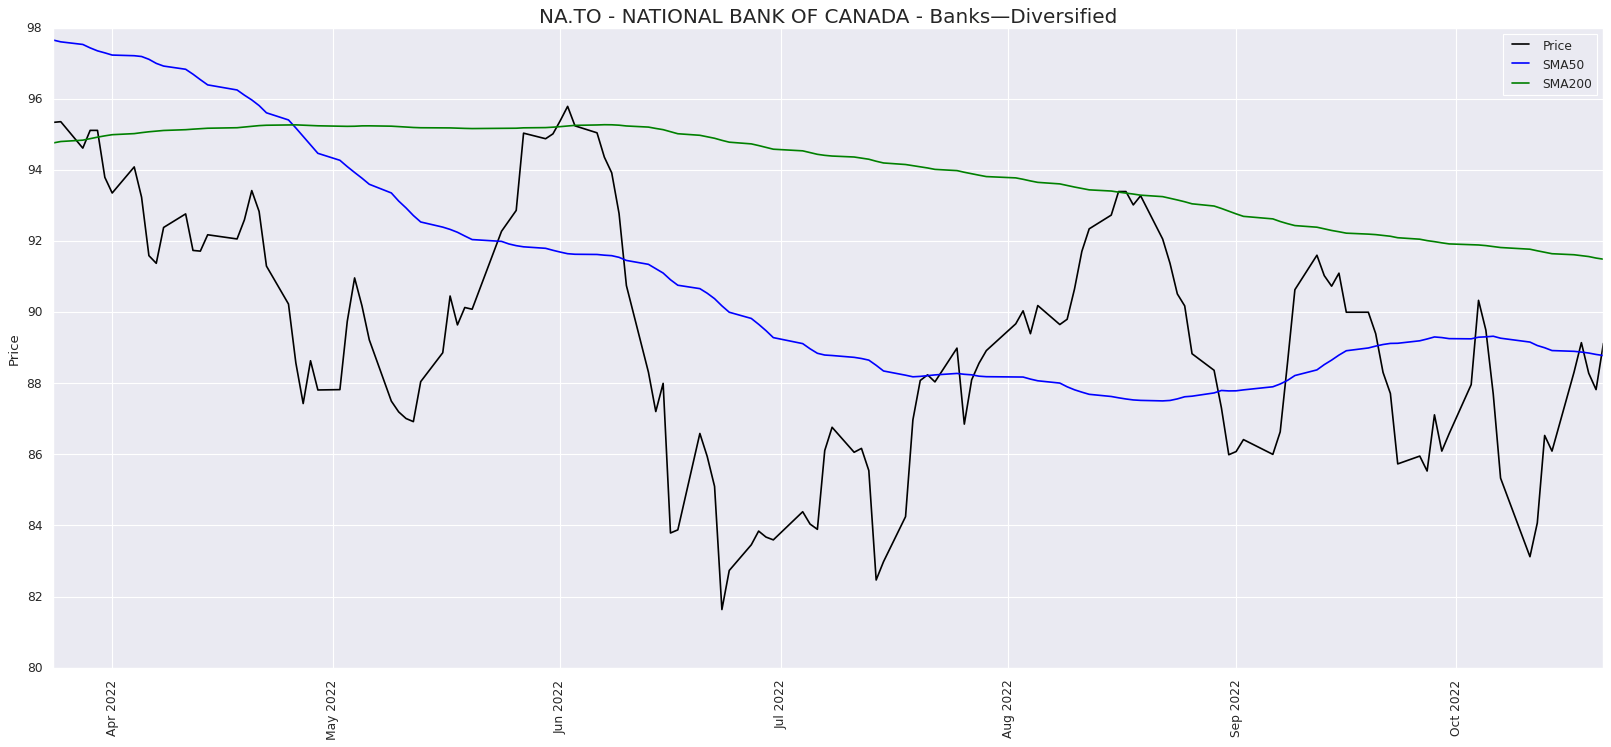

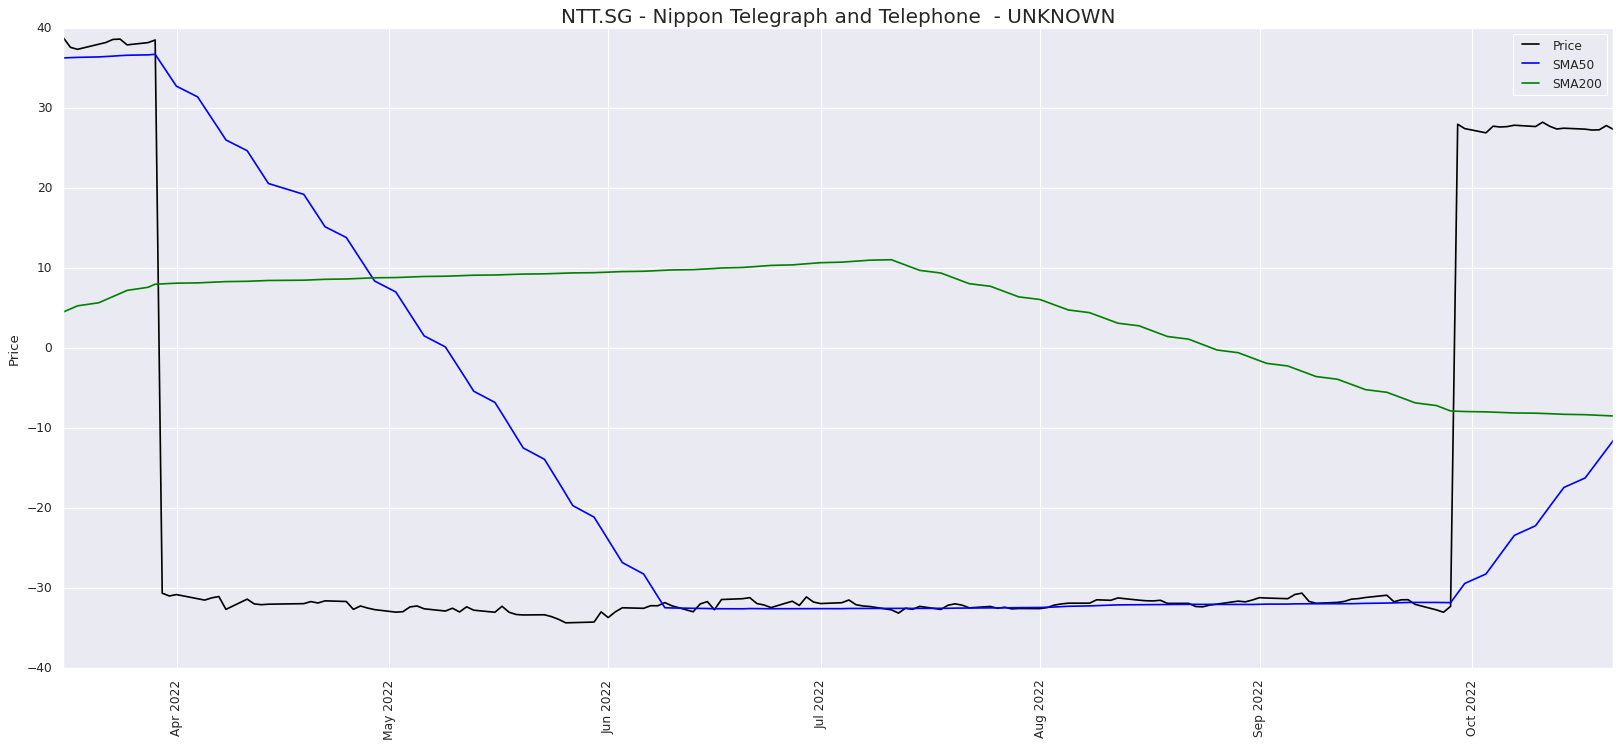

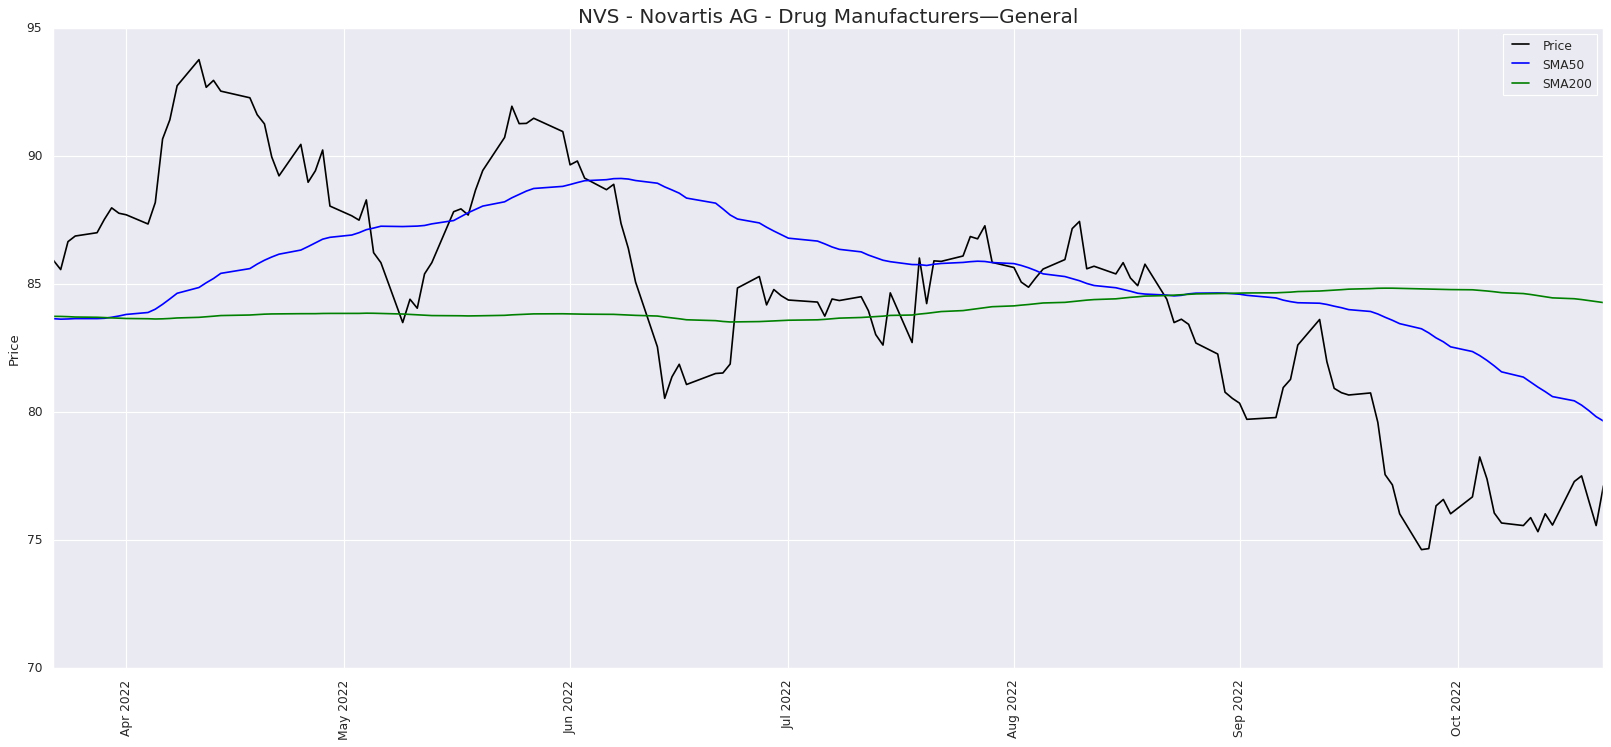

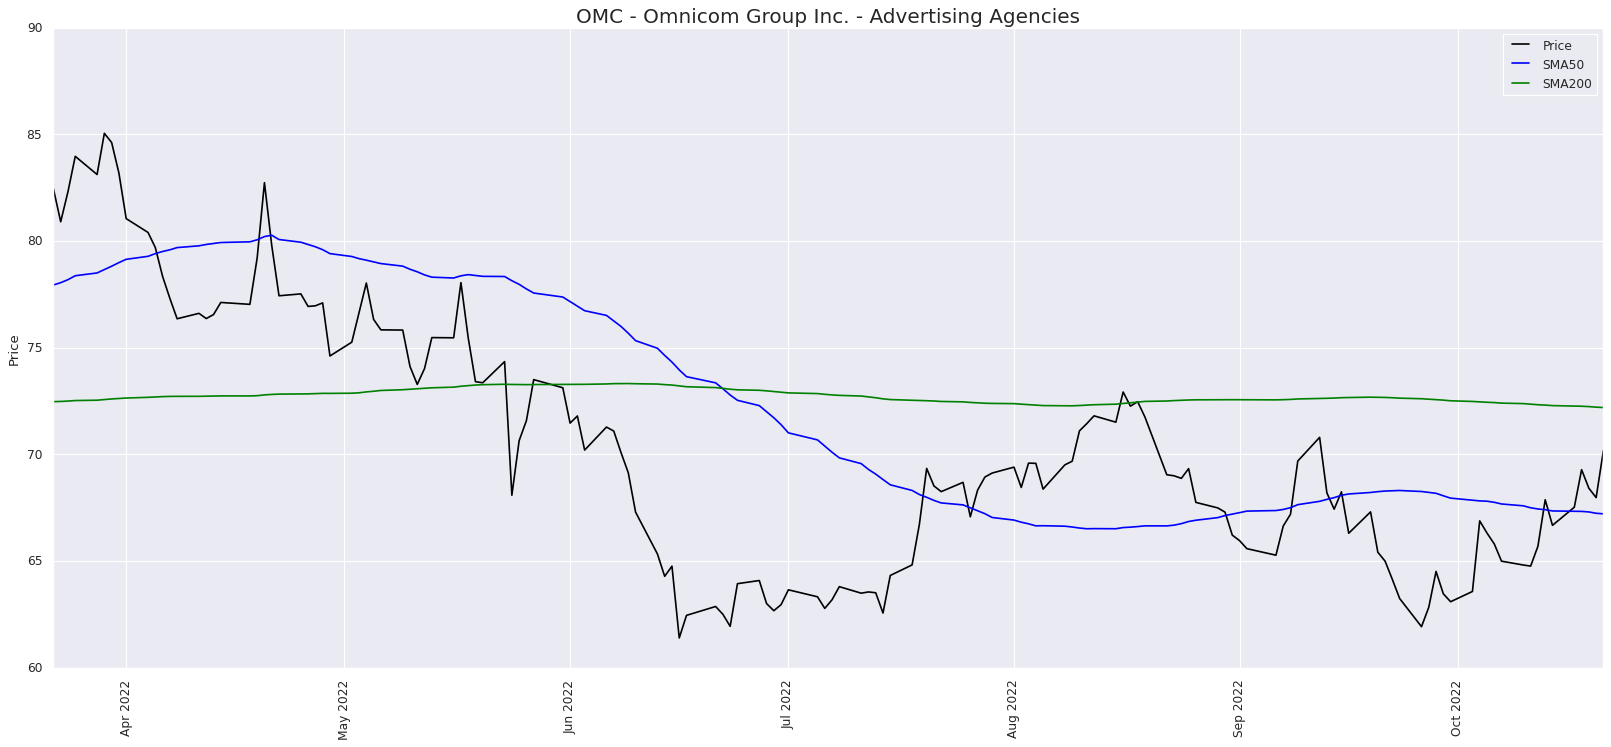

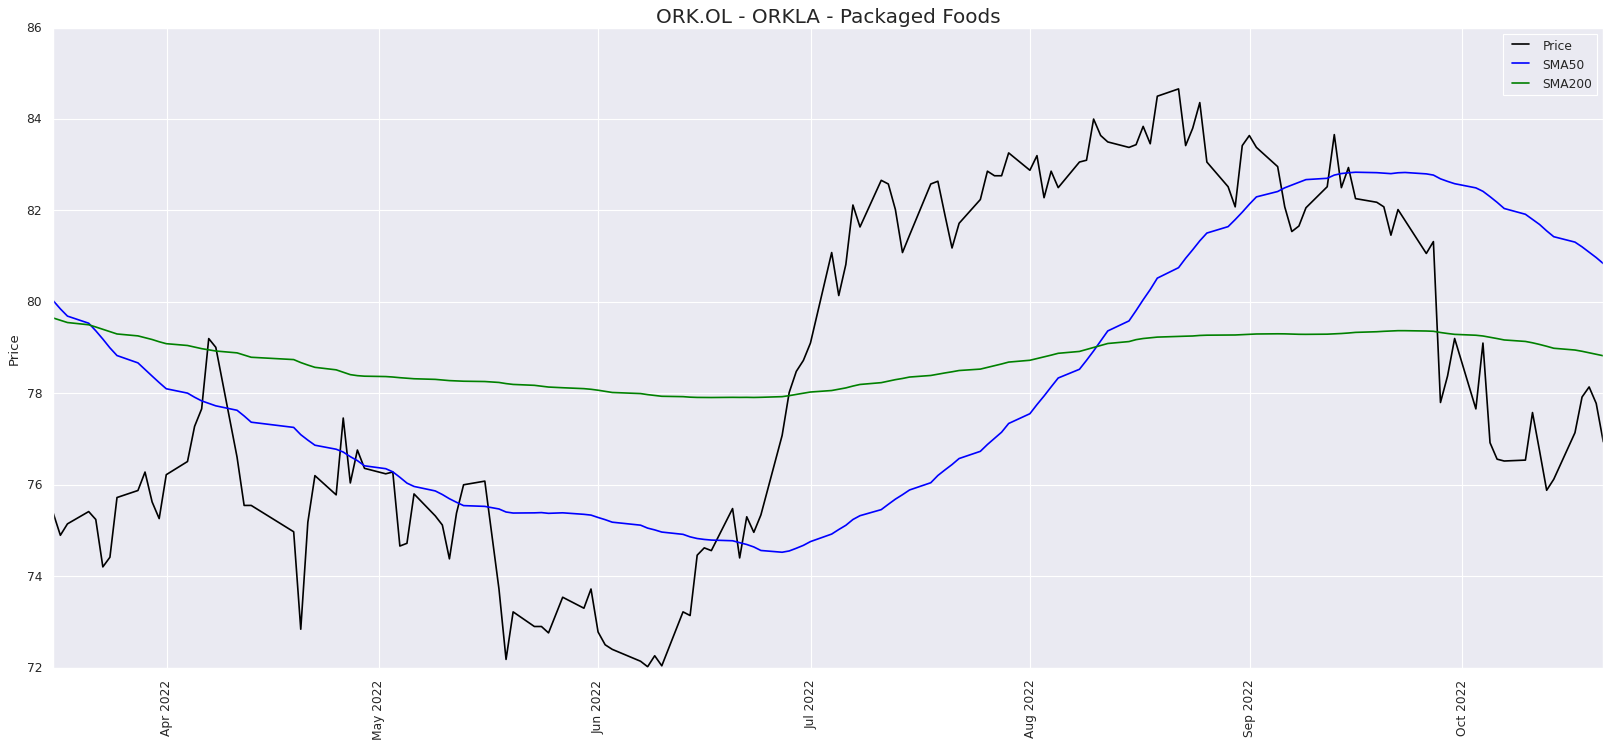

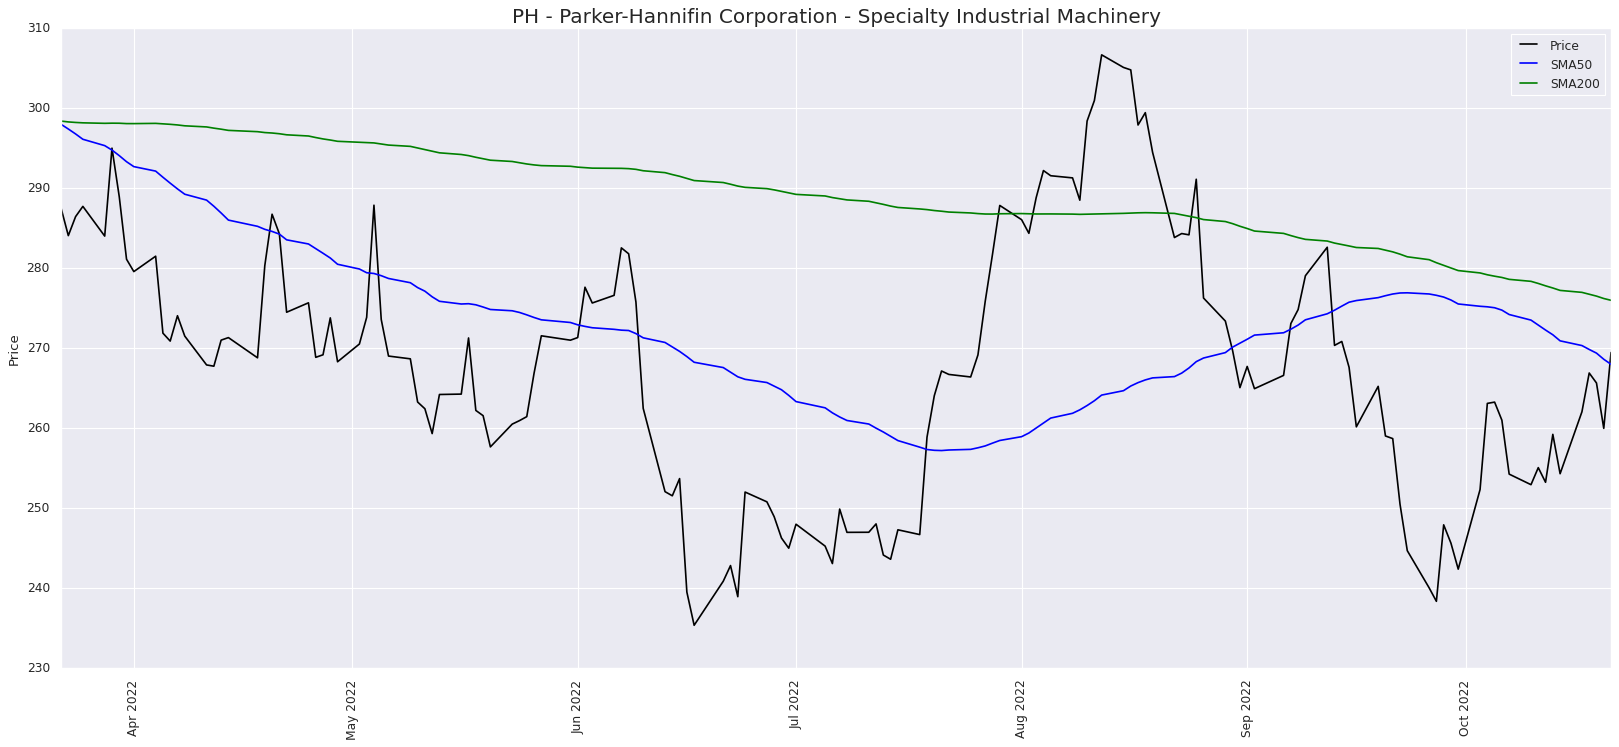

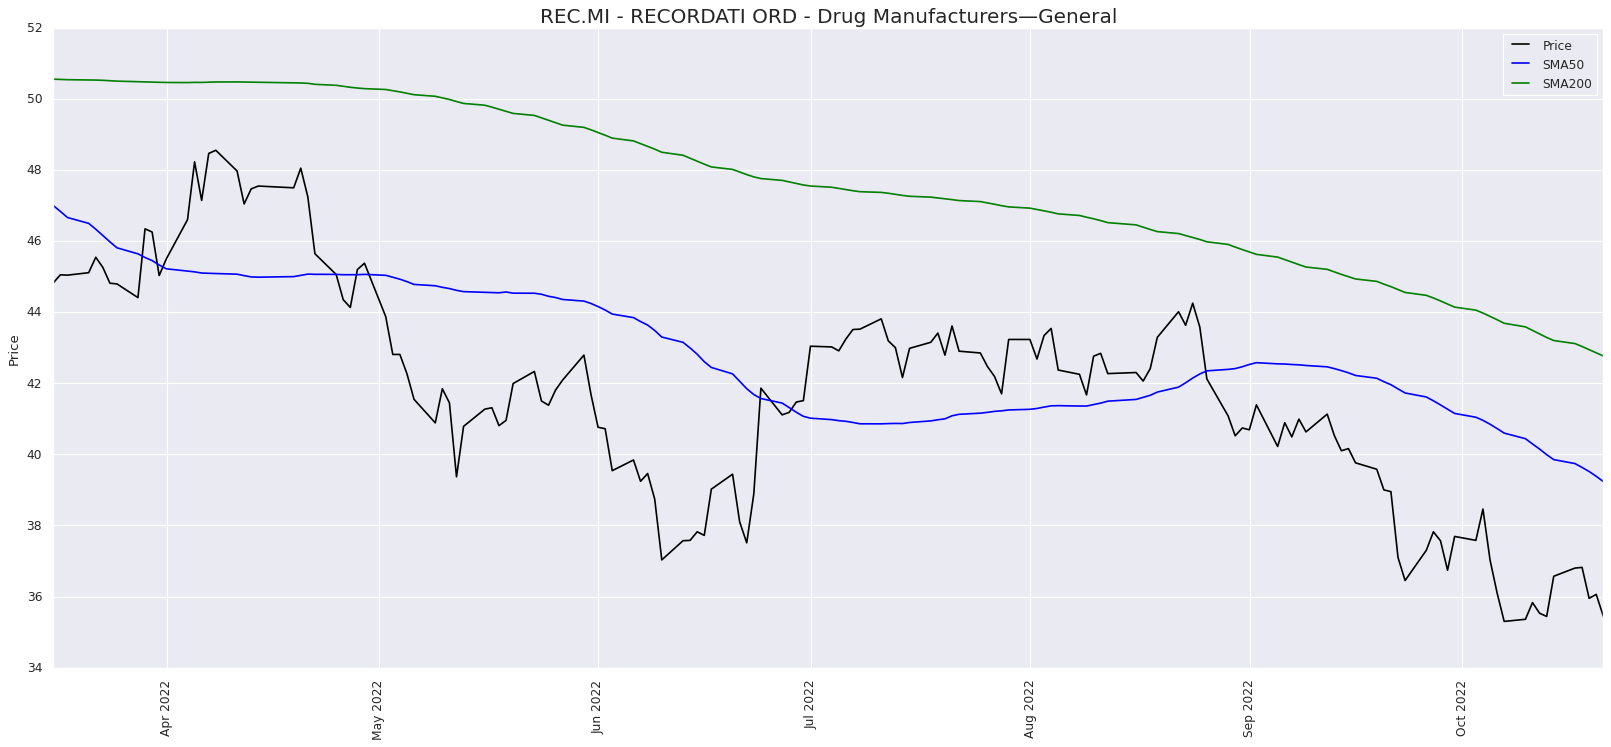

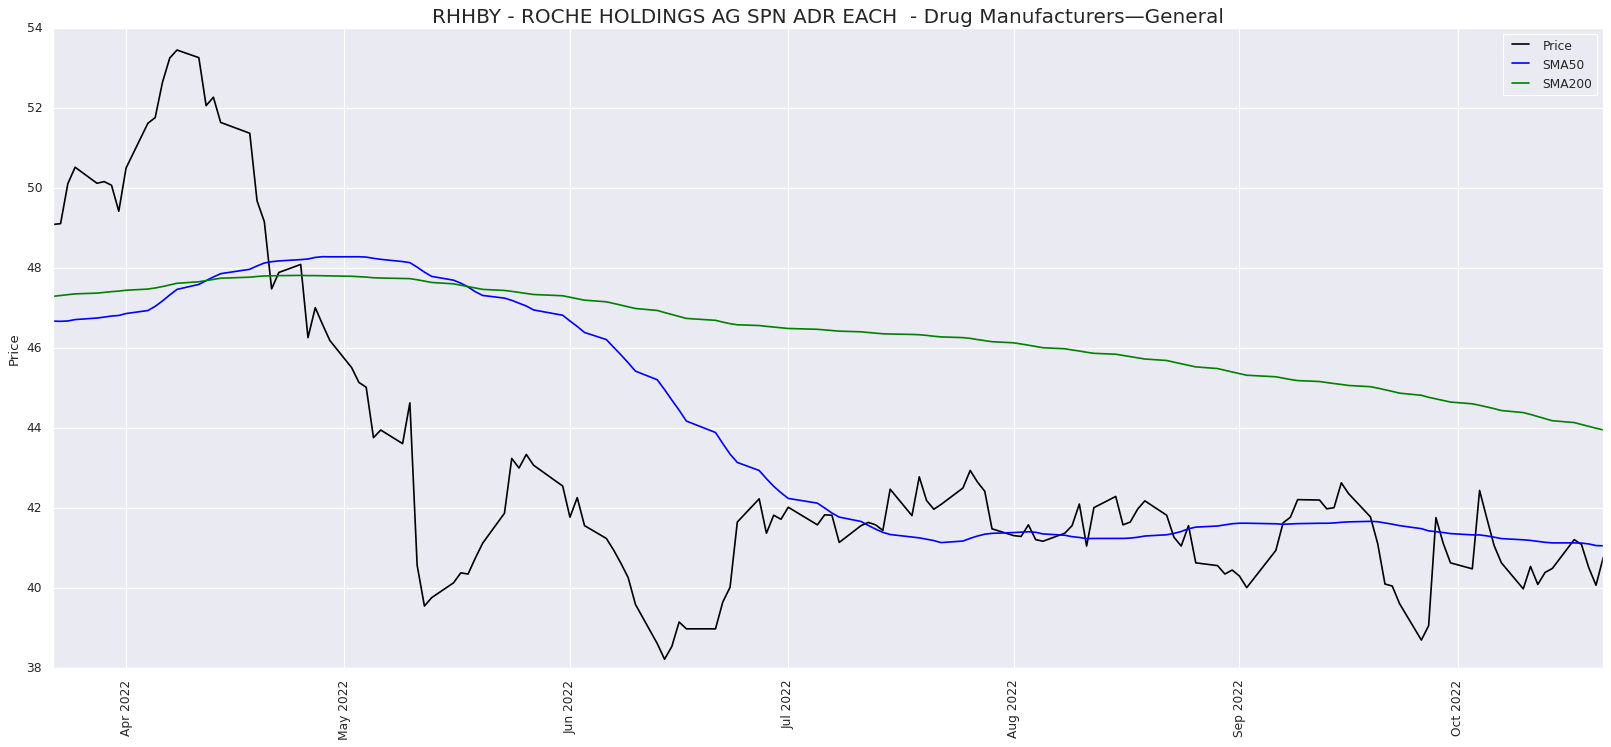

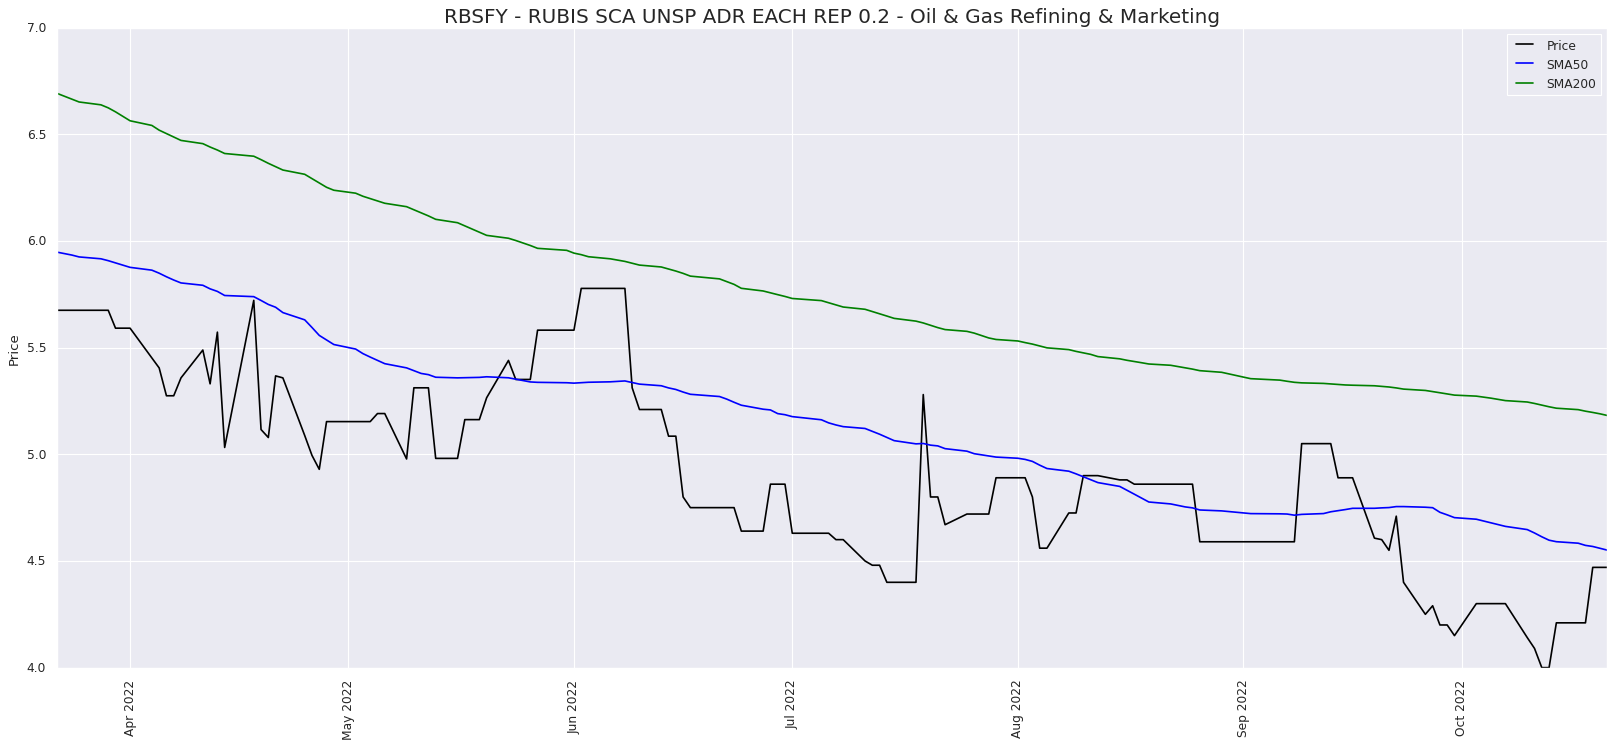

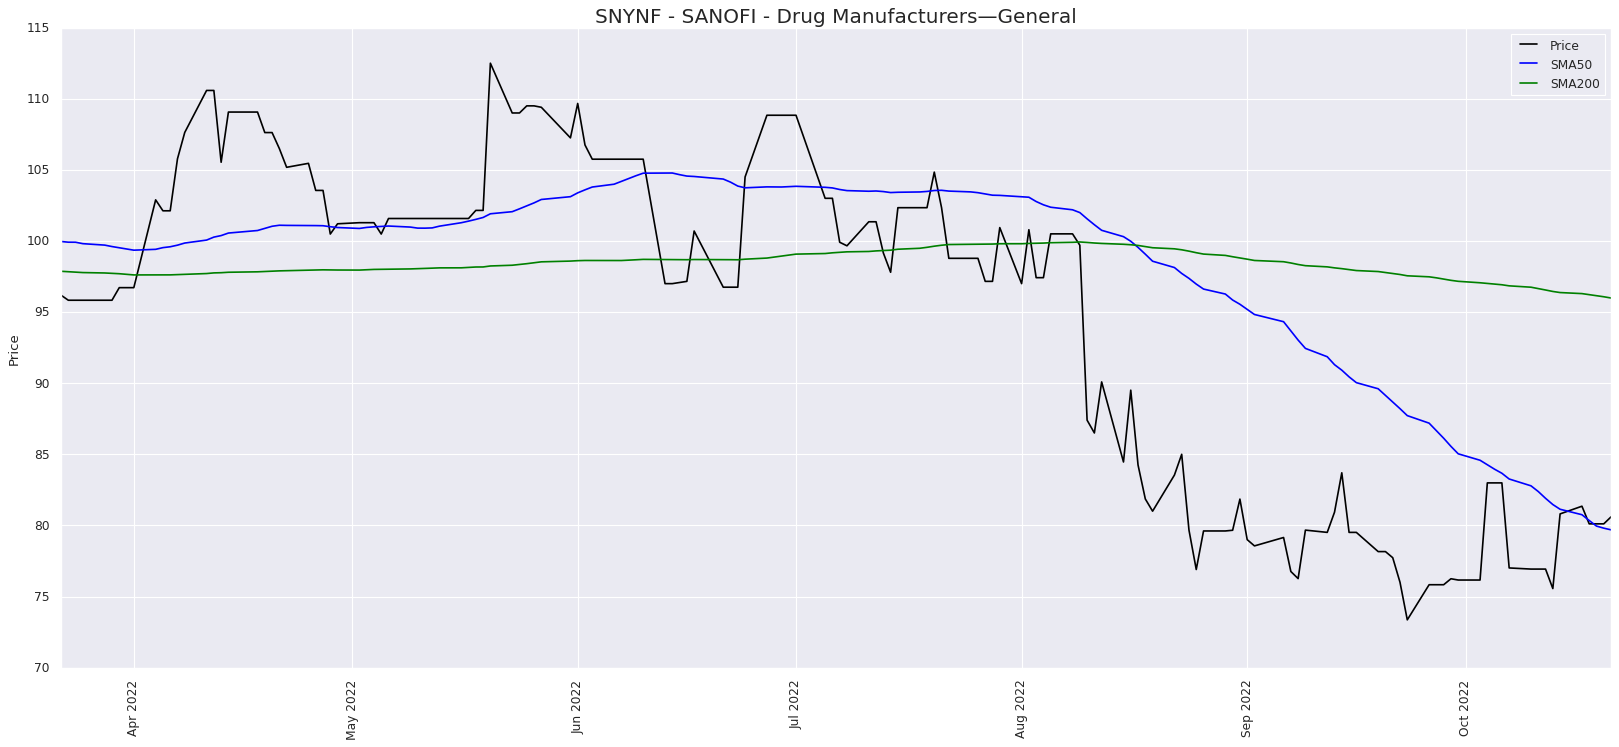

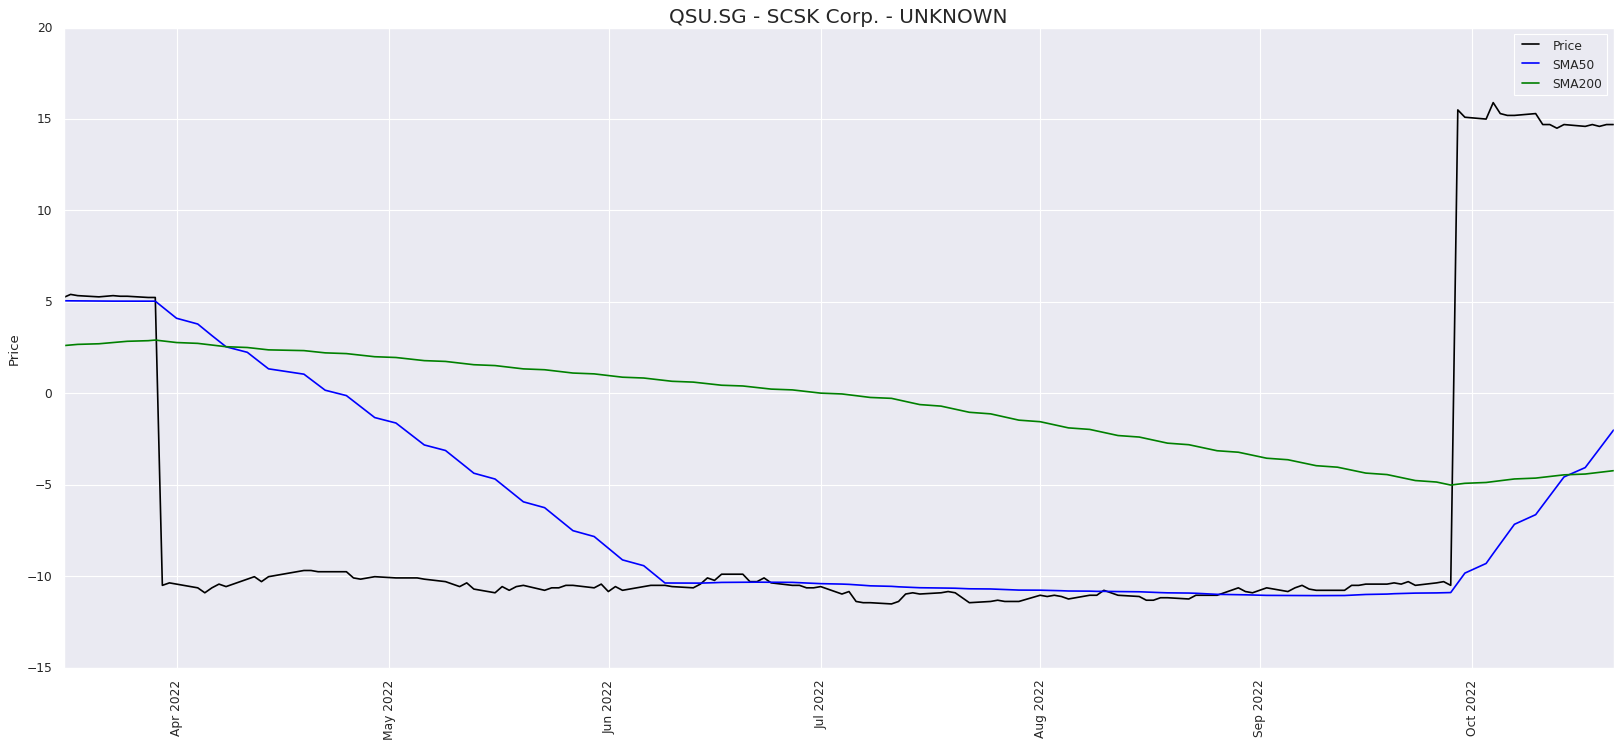

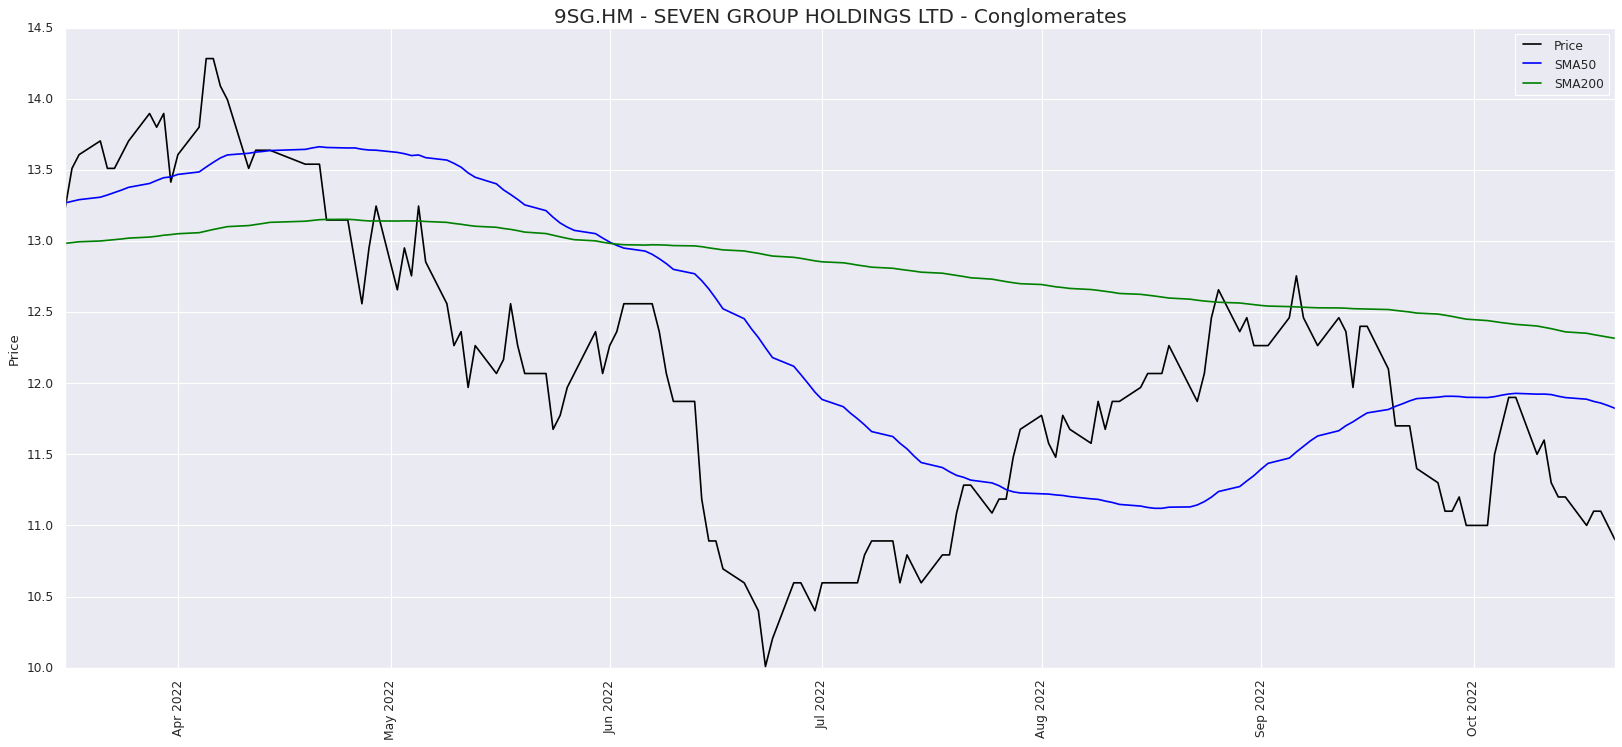

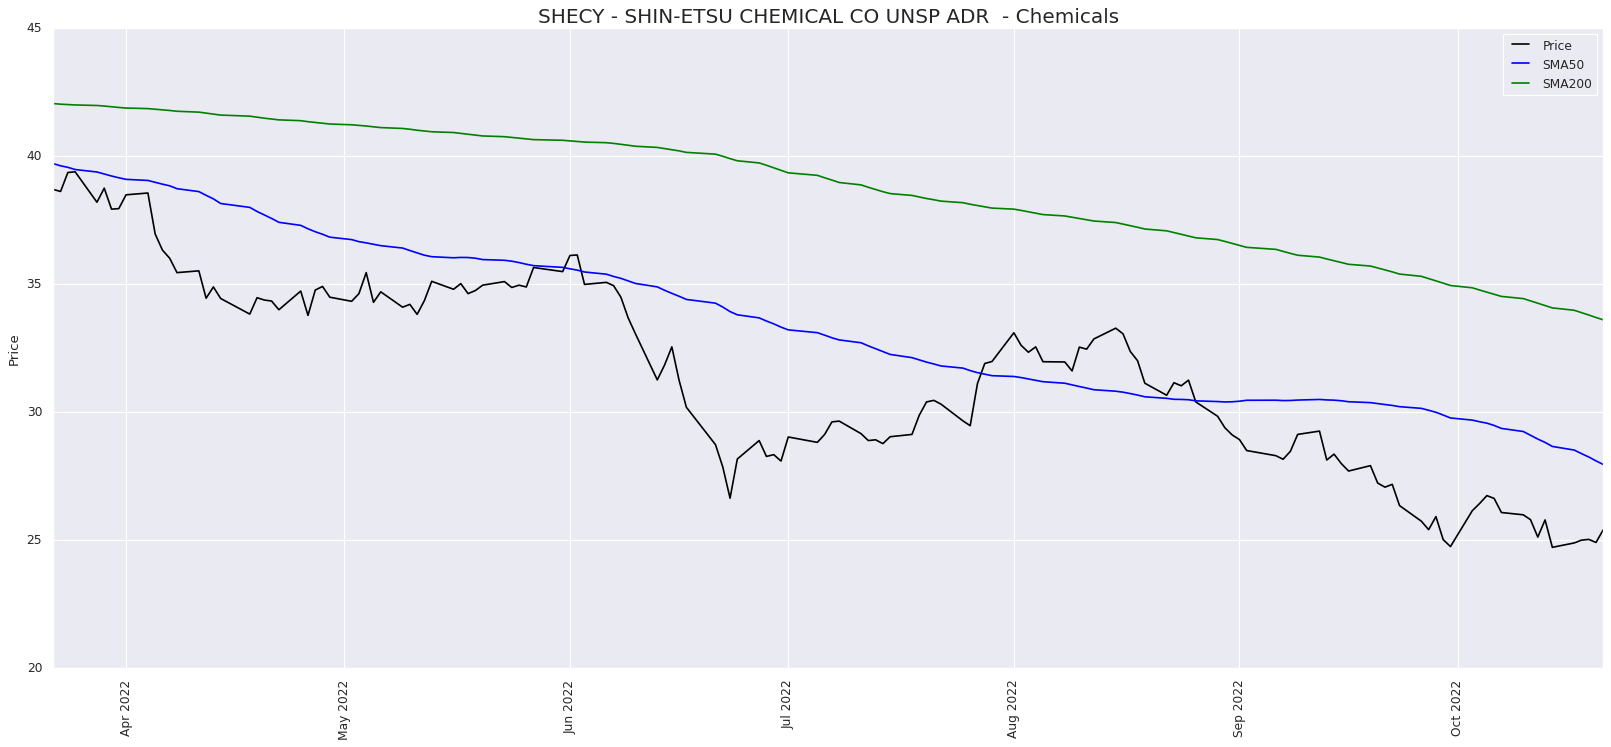

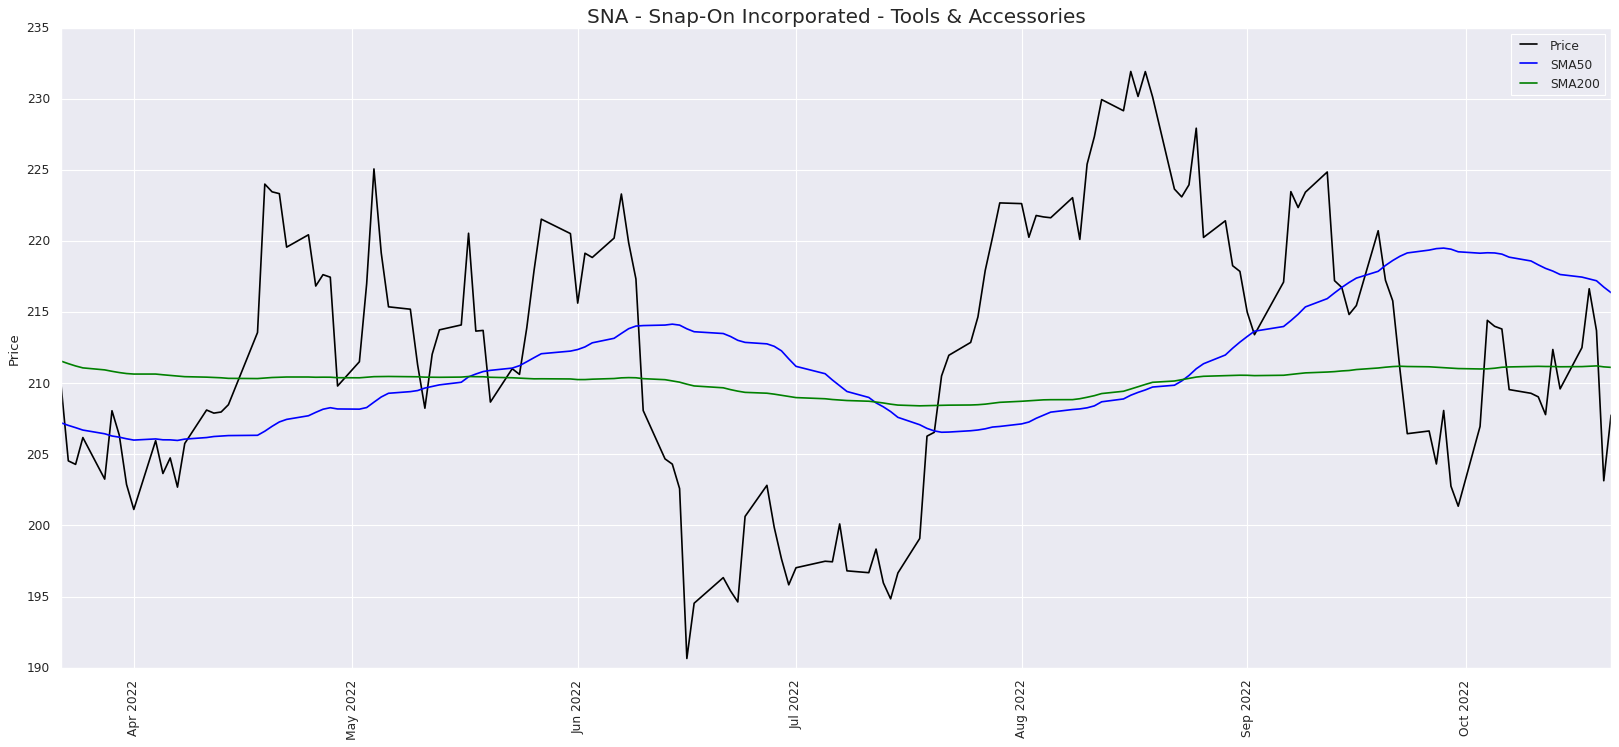

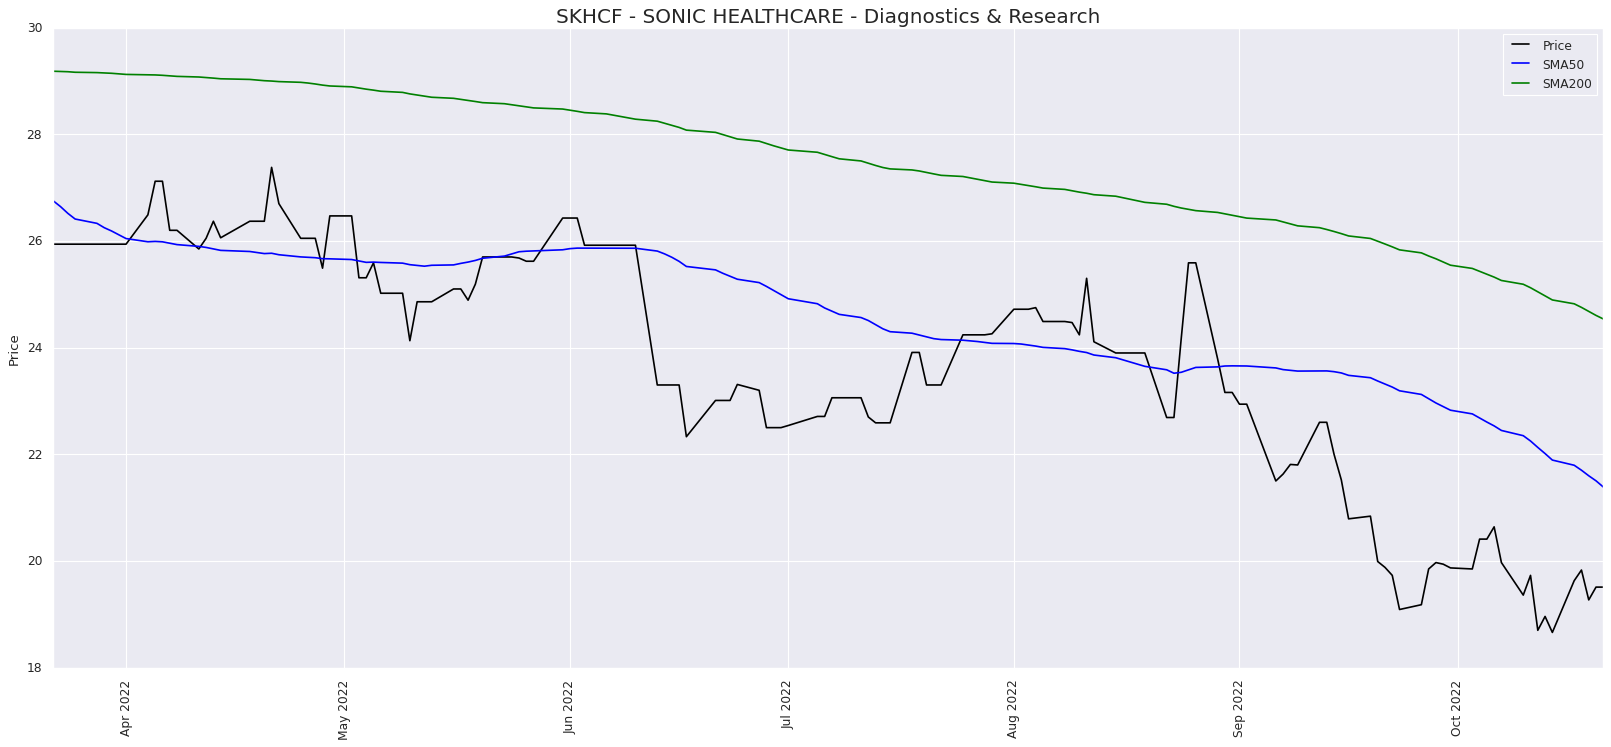

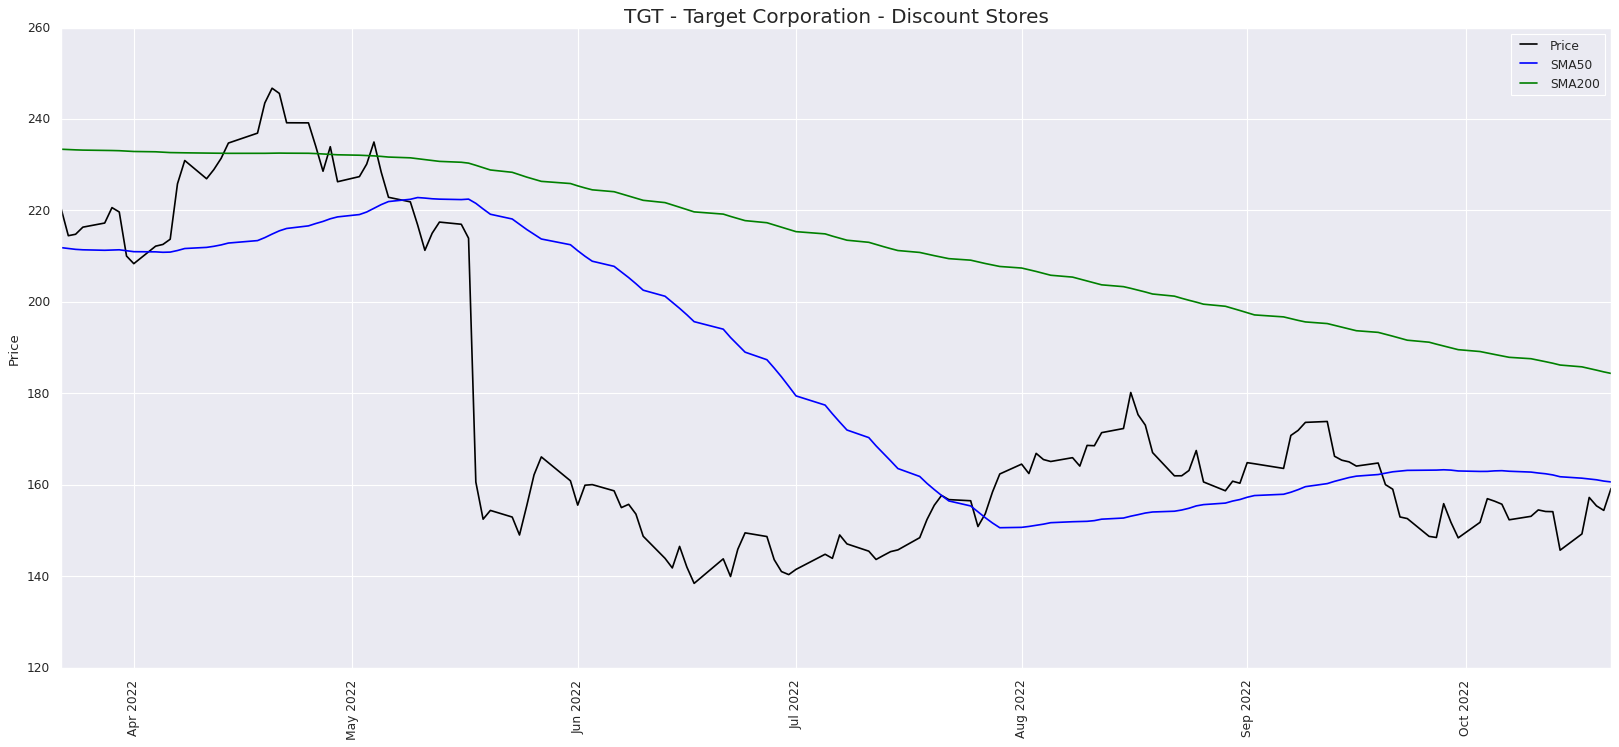

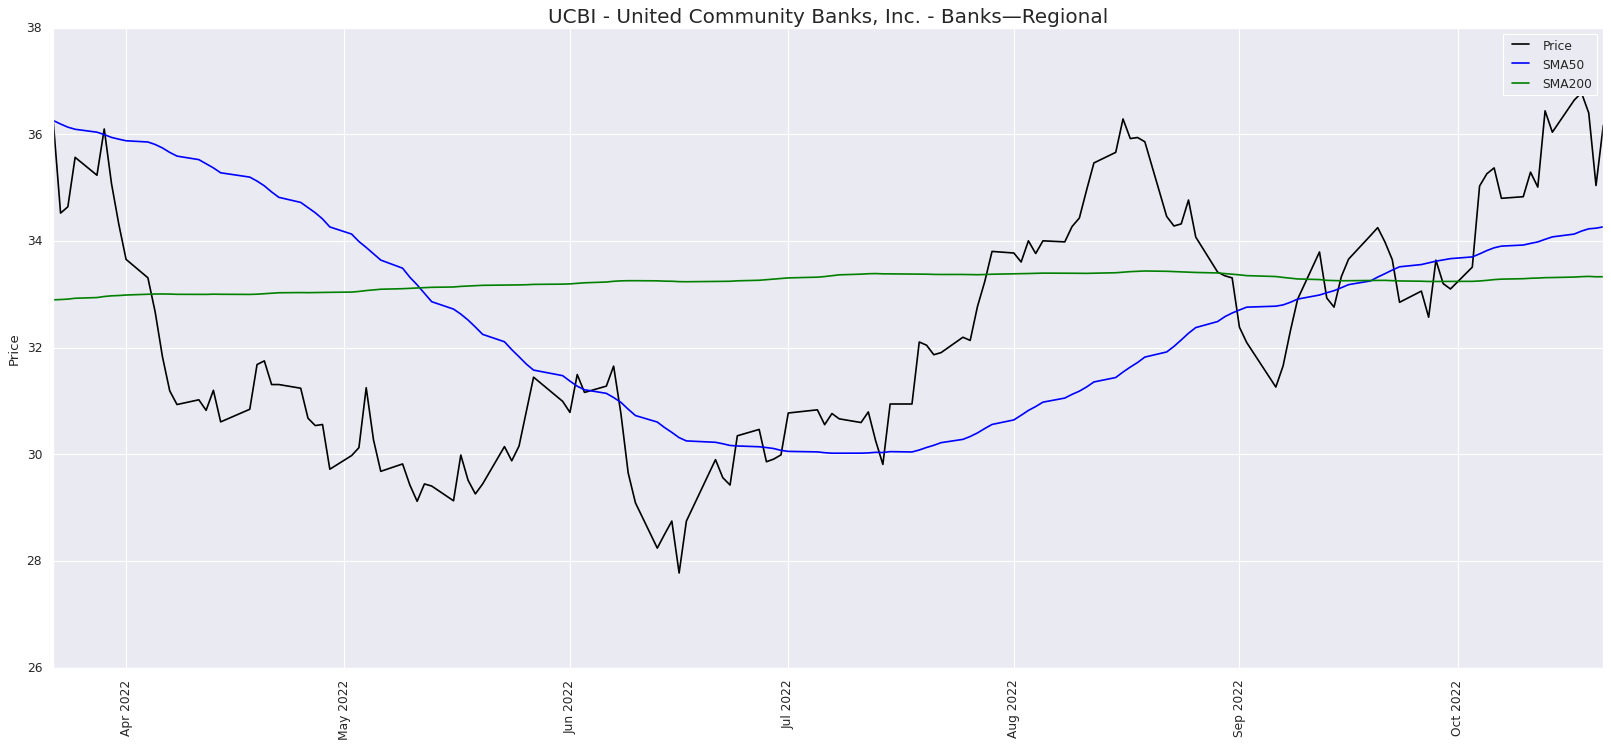

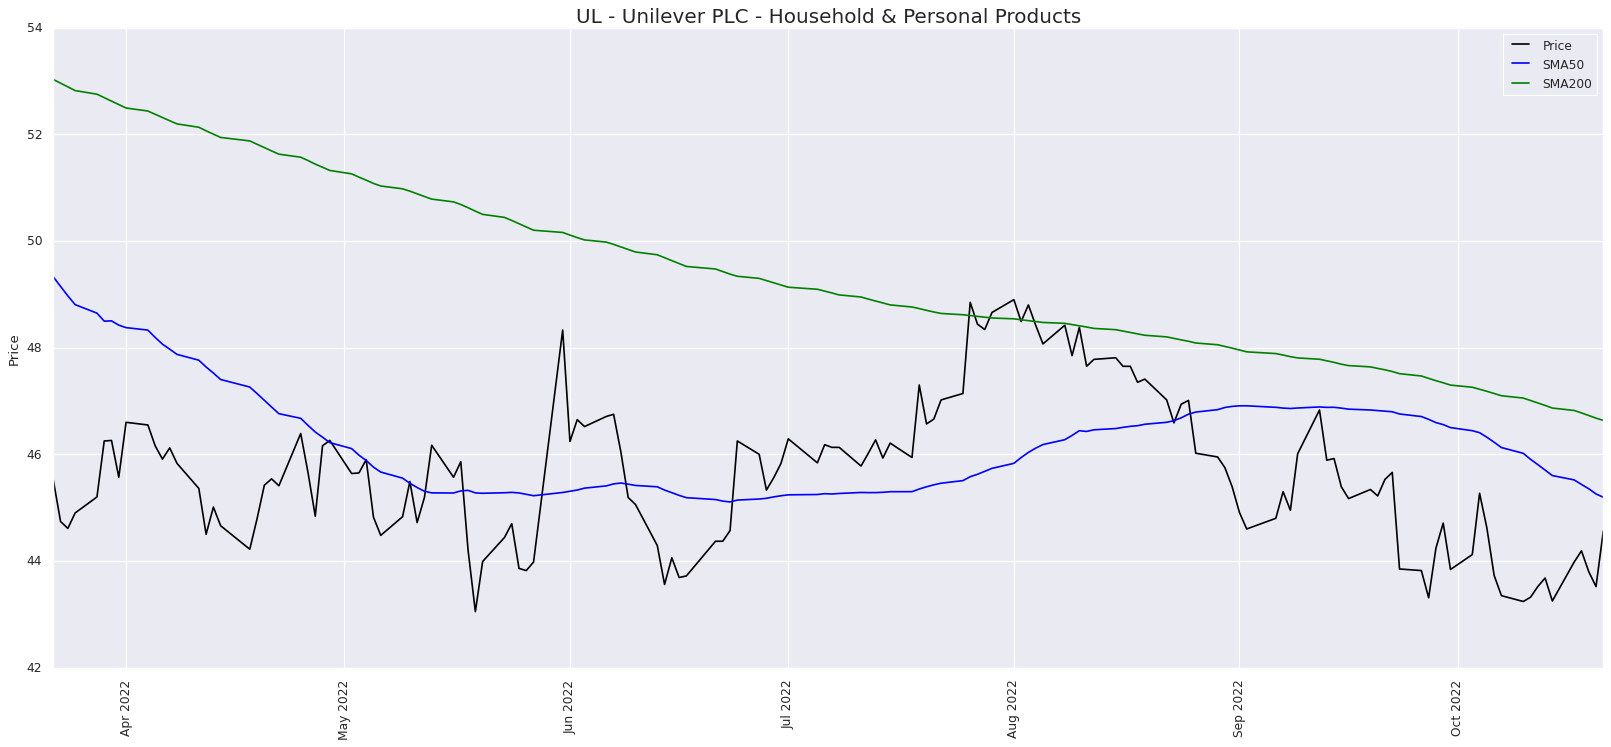

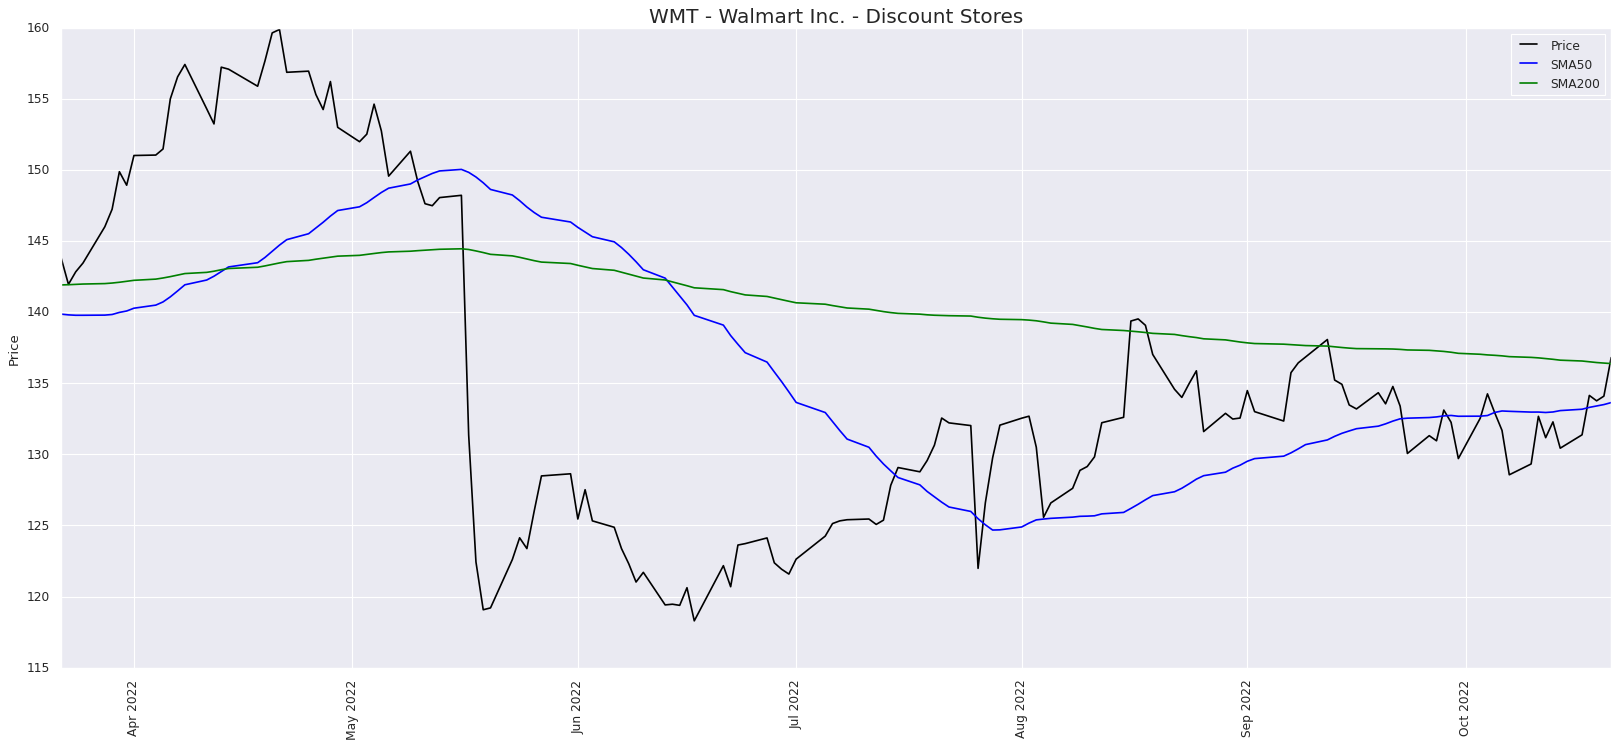

In [19]:
# lsTest = ['PEGY', 'PSX']
for t in ls:
    subset_df = tmp.copy()
    subset_df = subset_df[subset_df.Stock == t]
    # print(tmp.shape)
    
    if len(subset_df) > 0:
        gc_df = subset_df.copy()
        
        stock = gc_df.Stock.unique()
        name = stock_name[f'{stock[0]}']
        industry = stock_industry[f'{stock[0]}']
        
        end_date = max(gc_df.reset_index().Date)
        start_date = end_date - pd.Timedelta(days=500)

        gc_df = gc_df.reset_index()
        gc_df = gc_df[gc_df.Date >= start_date]
        gc_df = gc_df.set_index('Date')

        gc_df['sma50'] = gc_df['Close'].rolling(50, min_periods=50).mean()
        gc_df['sma200'] = gc_df['Close'].rolling(200, min_periods=200).mean()
        gc_df.dropna(inplace=True)   

        plt.figure(figsize=(25,10))
        plt.plot(gc_df["Close"], color="black", label="Price")
        plt.plot(gc_df["sma50"], color="blue", label="SMA50")
        plt.plot(gc_df["sma200"], color="green", label="SMA200")
        plt.ylabel("Price")
        plt.xticks(rotation=90)
        plt.title(f"{t} - {name} - {industry}", fontsize=18)
        plt.legend()
        
        path = f"{fp_plots}/{t}_{name}_{industry}_{date}.png"
        plt.savefig(path)
        # break
# tmp.head()

In [24]:
# convert all files matching a glob
with open(f"{pdf_path}/50_funds_for_life_{date}_test.pdf", "wb") as f:
    f.write(img2pdf.convert(glob.glob(f"{fp_plots}/*.png"))

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an a

KeyboardInterrupt: 